In [1]:
!pip install pandas
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# =========================
# PATH CONFIGURATION
# =========================
DATA_DIR = Path("/kaggle/input/smart-meters-in-london")
DAILY_DIR = DATA_DIR / "daily_dataset" / "daily_dataset"
SAVE_PATH = Path("/kaggle/working/finaldf.csv")

# =========================
# 1) MERGE 112 DAILY BLOCKS (keep only 3 required columns)
# =========================
usecols_energy = ["day", "LCLid", "energy_sum"]
dfs = []
for num in range(112):  # blocks 0..111
    f = DAILY_DIR / f"block_{num}.csv"
    if not f.exists():
        continue
    # read only necessary columns; keep LCLid as string to avoid numeric coercion
    df = pd.read_csv(f, usecols=usecols_energy, dtype={"LCLid": "string"})
    dfs.append(df)

# concatenate all blocks
energy = pd.concat(dfs, ignore_index=True)
# normalize date and drop invalid/duplicate daily records per household
energy["day"] = pd.to_datetime(energy["day"], errors="coerce").dt.date
energy = (
    energy.dropna(subset=["day", "LCLid", "energy_sum"])
          .drop_duplicates(subset=["LCLid", "day"])
)

# =========================
# 2) WEATHER (daily) → standardize 'day'
# =========================
weather = pd.read_csv(DATA_DIR / "weather_daily_darksky.csv")

# convert 'time' to datetime.date (supports both epoch seconds and ISO strings)
if np.issubdtype(weather["time"].dtype, np.number):
    day_dt = pd.to_datetime(weather["time"], unit="s", errors="coerce")
else:
    day_dt = pd.to_datetime(weather["time"], errors="coerce")
weather["day"] = day_dt.dt.date

# keep only documented weather columns + day, then deduplicate by day
weather_cols = [
    "temperatureMax","windBearing","dewPoint","cloudCover","windSpeed","pressure",
    "apparentTemperatureHigh","visibility","humidity","apparentTemperatureLow",
    "apparentTemperatureMax","uvIndex","temperatureLow","temperatureMin",
    "temperatureHigh","apparentTemperatureMin","moonPhase","day"
]
weather = (
    weather[[c for c in weather_cols if c in weather.columns]]
    .dropna(subset=["day"])
    .drop_duplicates(subset=["day"])
)

# =========================
# 3) UK BANK HOLIDAYS → add 'holiday' / 'weekend' flags
# =========================
holiday = pd.read_csv(DATA_DIR / "uk_bank_holidays.csv")
# the first column is the date; normalize to 'day'
holiday.rename(columns={holiday.columns[0]: "day"}, inplace=True)
holiday["day"] = pd.to_datetime(holiday["day"], errors="coerce").dt.date
holiday = holiday[["day"]].dropna().drop_duplicates()
holiday["is_holiday"] = 1

# merge energy + weather + holiday
df = energy.merge(weather, on="day", how="left")
df = df.merge(holiday[["day", "is_holiday"]], on="day", how="left")
df["is_holiday"] = df["is_holiday"].fillna(0).astype("int8")

# weekend flag from calendar
day_dt = pd.to_datetime(df["day"])
df["is_weekend"] = day_dt.dt.weekday.isin([5, 6]).astype("int8")

# combine into a single holiday flag (official holiday OR weekend)
df["holiday"] = ((df["is_holiday"] == 1) | (df["is_weekend"] == 1)).astype("int8")
df.drop(columns=["is_holiday", "is_weekend"], inplace=True)

# =========================
# 4) HOUSEHOLD INFO + ACORN MAPPING
# =========================
hh = (
    pd.read_csv(DATA_DIR / "informations_households.csv", dtype={"LCLid": "string"})
      .drop_duplicates(subset=["LCLid"])
)

# standardize column names if variants exist
rename_map = {"stdorToU": "Tariff", "Acorn": "AcornGroup", "Acorn_grouped": "Acorn_grouped"}
hh.rename(columns={k: v for k, v in rename_map.items() if k in hh.columns}, inplace=True)

# map ACORN code to high-level ACORN category
def acorn_category(code: str) -> str:
    if pd.isna(code): return "Unknown"
    code = str(code).strip()
    if code in ["ACORN-A","ACORN-B","ACORN-C"]: return "AffluentAcheivers"
    if code in ["ACORN-D","ACORN-E"]: return "RisingProsperity"
    if code in ["ACORN-F","ACORN-G","ACORN-H","ACORN-I","ACORN-J"]: return "ComfortableCommunities"
    if code in ["ACORN-K","ACORN-L","ACORN-M","ACORN-N"]: return "FinanciallyStretched"
    if code in ["ACORN-O","ACORN-P","ACORN-Q"]: return "UrbanAdversity"
    if code in ["ACORN-U","ACORN-"]: return "NotPrivateHouseholds"
    return "Unknown"

if "AcornGroup" in hh.columns:
    hh["AcornCategory"] = hh["AcornGroup"].apply(acorn_category)
else:
    hh["AcornCategory"] = "Unknown"

# readable ACORN group names
acorn_readable = {
 'ACORN-A':'LavishLifestyles','ACORN-B':'ExecutiveWealth','ACORN-C':'MatureMoney',
 'ACORN-D':'CitySophisticates','ACORN-E':'CareerClimbers','ACORN-F':'CountrysideCommunities',
 'ACORN-G':'SuccessfulSuburbs','ACORN-H':'SteadyNeighbourhoods','ACORN-I':'ComfortableSeniors',
 'ACORN-J':'StartingOut','ACORN-K':'StudentLife','ACORN-L':'ModestMeans','ACORN-M':'StrivingFamilies',
 'ACORN-N':'PoorerPensioners','ACORN-O':'YoungHardship','ACORN-P':'StrugglingEstates',
 'ACORN-Q':'DifficultCircumstances','ACORN-U':'NotPrivateHouseholds','ACORN-':'NotPrivateHouseholds'
}
if "AcornGroup" in hh.columns:
    hh["AcornGroup"] = hh["AcornGroup"].map(acorn_readable).fillna("Unknown")

# attach household metadata to the daily table
df = df.merge(hh[["LCLid","Tariff","AcornGroup","AcornCategory"]], on="LCLid", how="left")

# =========================
# 5) LIGHT CLEANUP & SAVE
# =========================
# enforce dtypes for categorical columns
df["LCLid"] = df["LCLid"].astype("string")
df["Tariff"] = df["Tariff"].astype("string")
df["AcornGroup"] = df["AcornGroup"].astype("string")
df["AcornCategory"] = df["AcornCategory"].astype("string")

# final deduplication and essential NA drop
df = df.drop_duplicates().dropna(subset=["day","LCLid","energy_sum"])

# write merged dataset
df.to_csv(SAVE_PATH, index=False)

# quick summary
print("Saved:", SAVE_PATH)
print("Rows:", len(df), "| Unique households:", df["LCLid"].nunique())
print("Date range:", df["day"].min(), "→", df["day"].max())
print("Columns:", list(df.columns))


Saved: /kaggle/working/finaldf.csv
Rows: 3510403 | Unique households: 5561
Date range: 2011-11-23 → 2014-02-28
Columns: ['LCLid', 'day', 'energy_sum', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'holiday', 'Tariff', 'AcornGroup', 'AcornCategory']


In [3]:
import pandas as pd 
from pathlib import Path 

IN_CSV = Path("/kaggle/working/finaldf.csv") 
OUT_CSV = Path("/kaggle/working/finaldf_169.csv") 
N_KEEP = 169
# 1) Load & chuẩn hóa tối thiểu 
df = pd.read_csv(IN_CSV, low_memory=False) 
df["day"] = pd.to_datetime(df["day"], errors="coerce")

# 2) Ưu tiên hộ có Tariff dToU/ToU (như paper). Nếu không đủ 169 -> fallback toàn bộ. 

mask_tou = df["Tariff"].astype(str).str.contains("tou", case=False, na=False) | df["Tariff"].astype(str).str.contains("dto", case=False, na=False) 
df_tou = df[mask_tou].copy() 
base = df_tou if df_tou["LCLid"].nunique() >= N_KEEP else df.copy()

# 3) Chọn 169 hộ: nhiều ngày nhất, rồi ưu tiên bắt đầu sớm (ổn cho chuỗi dài) 
agg = (base.groupby("LCLid") .agg(n_days=("day","nunique"), first_day=("day","min"), last_day=("day","max")) .reset_index()) 
agg = agg.sort_values(["n_days","first_day"], ascending=[False, True]) 
keep_ids = agg["LCLid"].head(N_KEEP).tolist() 
df_169 = df[df["LCLid"].isin(keep_ids)].copy() 
# 4) Lưu file dùng để training 
df_169.to_csv(OUT_CSV, index=False) 
# 5) In gọn thông tin cần 
print("Saved:", OUT_CSV) 
print("Rows:", len(df_169), "| Unique households:", df_169["LCLid"].nunique()) 
print("Date range:", df_169["day"].min().date(), "→", df_169["day"].max().date())

Saved: /kaggle/working/finaldf_169.csv
Rows: 128573 | Unique households: 169
Date range: 2011-11-23 → 2014-02-28


In [4]:
# =========================
# EDA for finaldf_169.csv
# =========================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.dates import DateFormatter

# ---------- 0) SETUP ----------
sns.set_theme(style="whitegrid", context="talk")  # nice default style
plt.rcParams["figure.figsize"] = (10, 6)         # default figure size

DF_PATH = Path("/kaggle/working/finaldf_169.csv")
assert DF_PATH.exists(), f"File not found: {DF_PATH}"

# ---------- 1) LOAD DATA ----------
df = pd.read_csv(DF_PATH, low_memory=False)

# convert 'day' column to datetime
df["day"] = pd.to_datetime(df["day"], errors="coerce")

# drop rows with missing key fields
df = df.dropna(subset=["day","LCLid","energy_sum"]).copy()
df["LCLid"] = df["LCLid"].astype(str)

# ---------- 2) HOLIDAY HANDLING ----------
# ensure holiday column is numeric binary (0/1) if it exists
if "holiday" in df.columns:
    df["holiday"] = pd.to_numeric(df["holiday"], errors="coerce").fillna(0).astype(int)

# ---------- 3) WEATHER COLUMNS ----------
# list of potential weather features (may not all exist in dataset)
weather_cols_all = [
    "temperatureMax","windBearing","dewPoint","cloudCover","windSpeed","pressure",
    "apparentTemperatureHigh","visibility","humidity","apparentTemperatureLow",
    "apparentTemperatureMax","uvIndex","temperatureLow","temperatureMin",
    "temperatureHigh","apparentTemperatureMin","moonPhase"
]
wcols = [c for c in weather_cols_all if c in df.columns]

# ---------- 4) TIME HELPERS ----------
# extract year, month, weekday for seasonal/temporal analysis
df["year"] = df["day"].dt.year
df["month"] = df["day"].dt.to_period("M").astype(str)
df["weekday"] = df["day"].dt.weekday  # 0=Mon .. 6=Sun
weekday_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
df["weekday_name"] = df["weekday"].map(weekday_map)

# ---------- 5) SUMMARY ----------
print("Rows:", len(df), "| Unique households:", df["LCLid"].nunique())
print("Date range:", df["day"].min().date(), "→", df["day"].max().date())
print("Columns:", list(df.columns))


Rows: 128573 | Unique households: 169
Date range: 2011-11-23 → 2014-02-28
Columns: ['LCLid', 'day', 'energy_sum', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'holiday', 'Tariff', 'AcornGroup', 'AcornCategory', 'year', 'month', 'weekday', 'weekday_name']


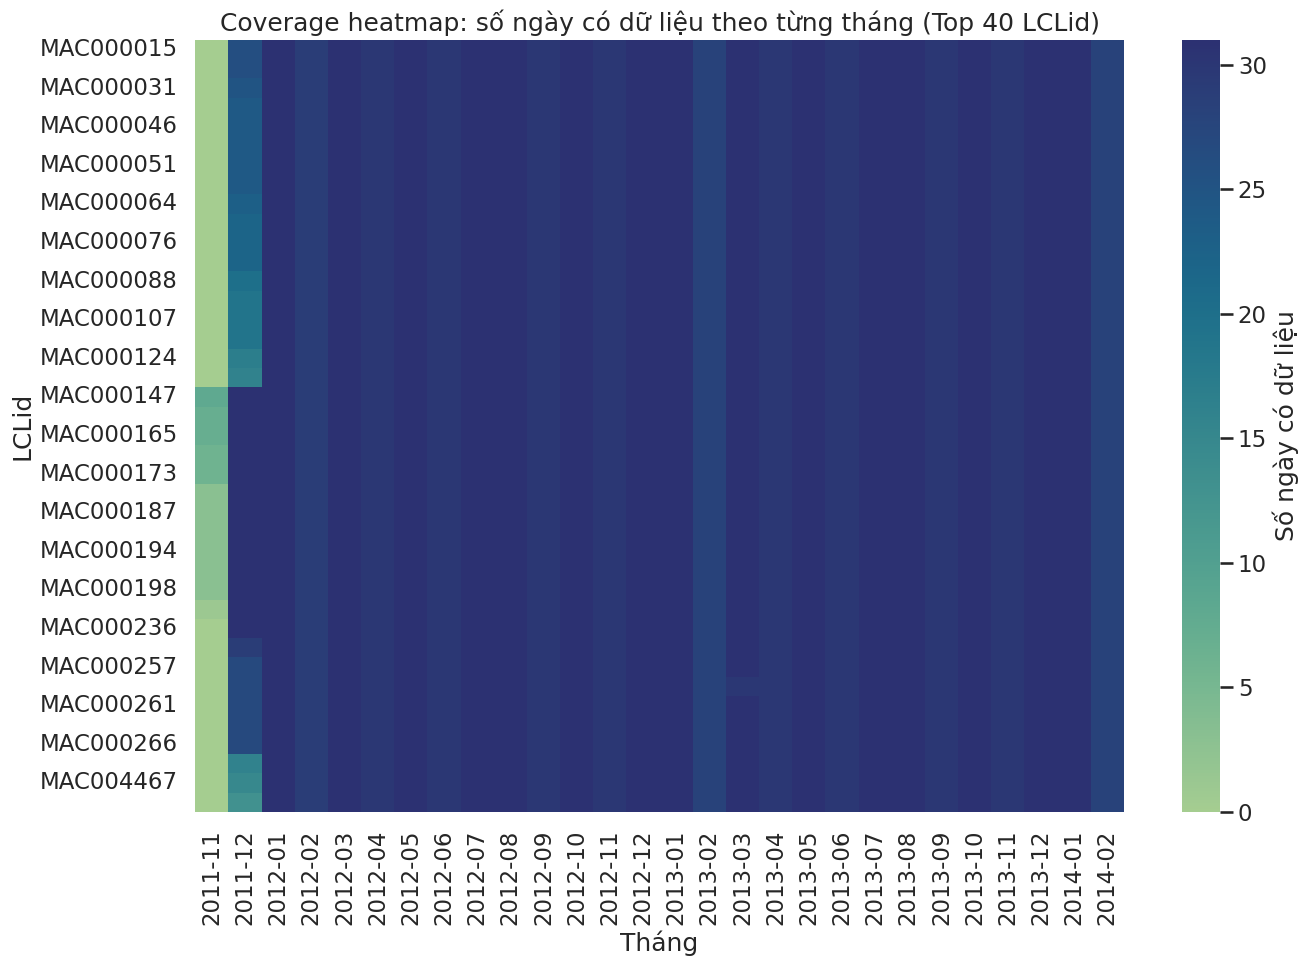

In [5]:
# ---------- 1) COVERAGE HEATMAP ----------
# Count number of available days per (LCLid, month)
cov = (
    df.assign(val=1)                             # mark each row as 1
      .groupby(["LCLid","month"], as_index=False)["val"].sum()
)

# Select top 40 households with the most active days
top_ids = (
    df.groupby("LCLid")["day"].nunique()
      .sort_values(ascending=False)
      .head(40).index.tolist()
)

# Filter coverage to top households only
cov_top = cov[cov["LCLid"].isin(top_ids)]

# Pivot into matrix: rows=LCLid, columns=month, values=#days
cov_piv = cov_top.pivot(index="LCLid", columns="month", values="val").fillna(0)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(cov_piv, cmap="crest", cbar_kws={"label": "Number of days"})
plt.title("Coverage heatmap: number of days with data per month (Top 40 LCLid)")
plt.xlabel("Month"); plt.ylabel("LCLid")
plt.tight_layout(); plt.show()


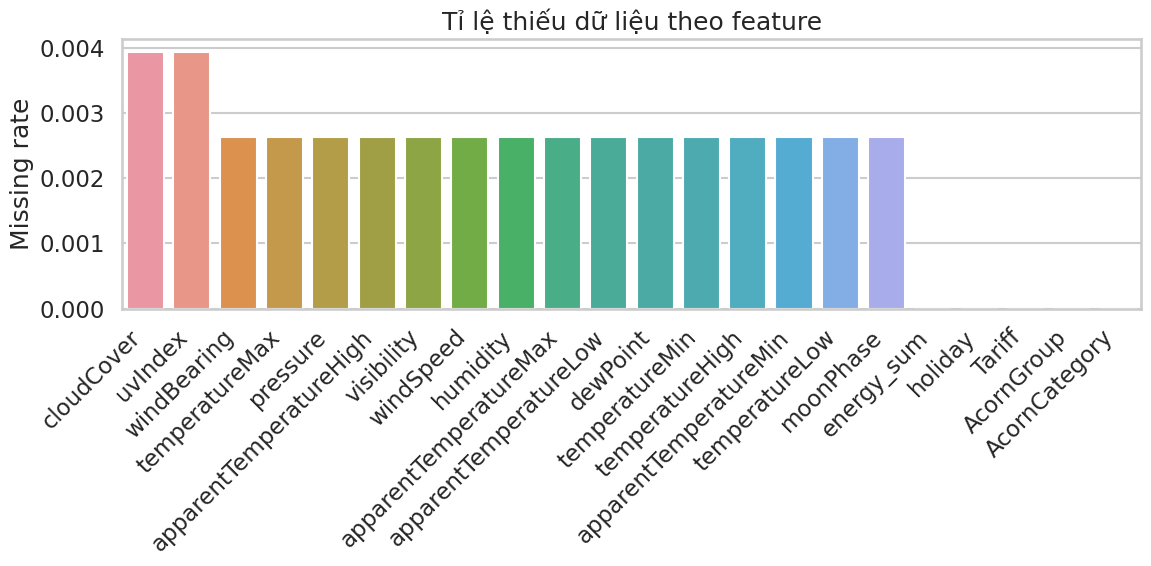

In [6]:
# ---------- 2) MISSINGNESS (per column) ----------
# Calculate missing rate (%) for each column
miss_rate = df.isna().mean().sort_values(ascending=False)

# Convert into tidy DataFrame
miss_df = miss_rate.reset_index()
miss_df.columns = ["feature","missing_rate"]

# Keep only selected features: target, holiday, tariff, ACORN, and weather columns
miss_df = miss_df[
    miss_df["feature"].isin(
        ["energy_sum","holiday","Tariff","AcornGroup","AcornCategory"] + wcols
    )
]

# Plot missingness as bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=miss_df, x="feature", y="missing_rate")
plt.xticks(rotation=45, ha="right")
plt.title("Missing data rate by feature")
plt.ylabel("Missing rate"); plt.xlabel("")
plt.tight_layout(); plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


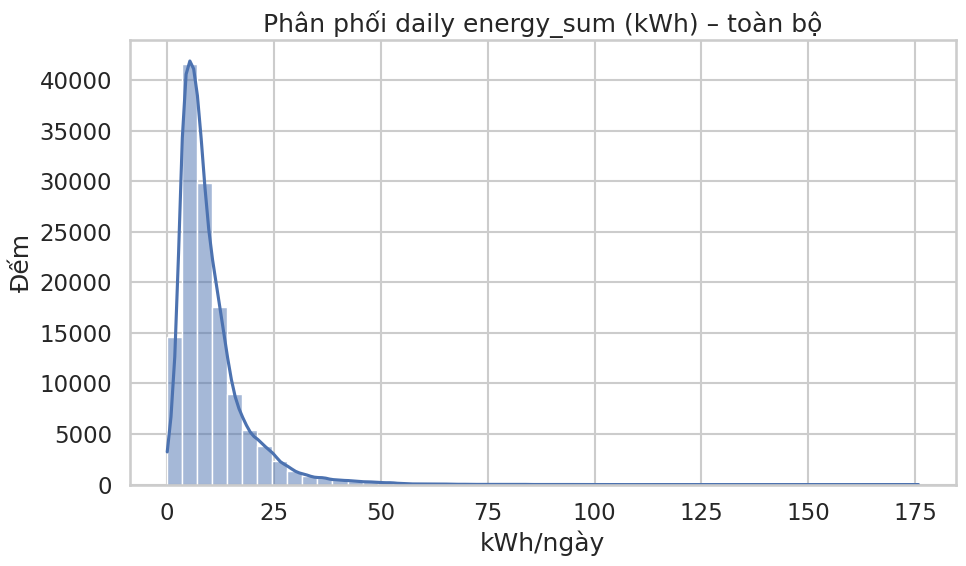

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

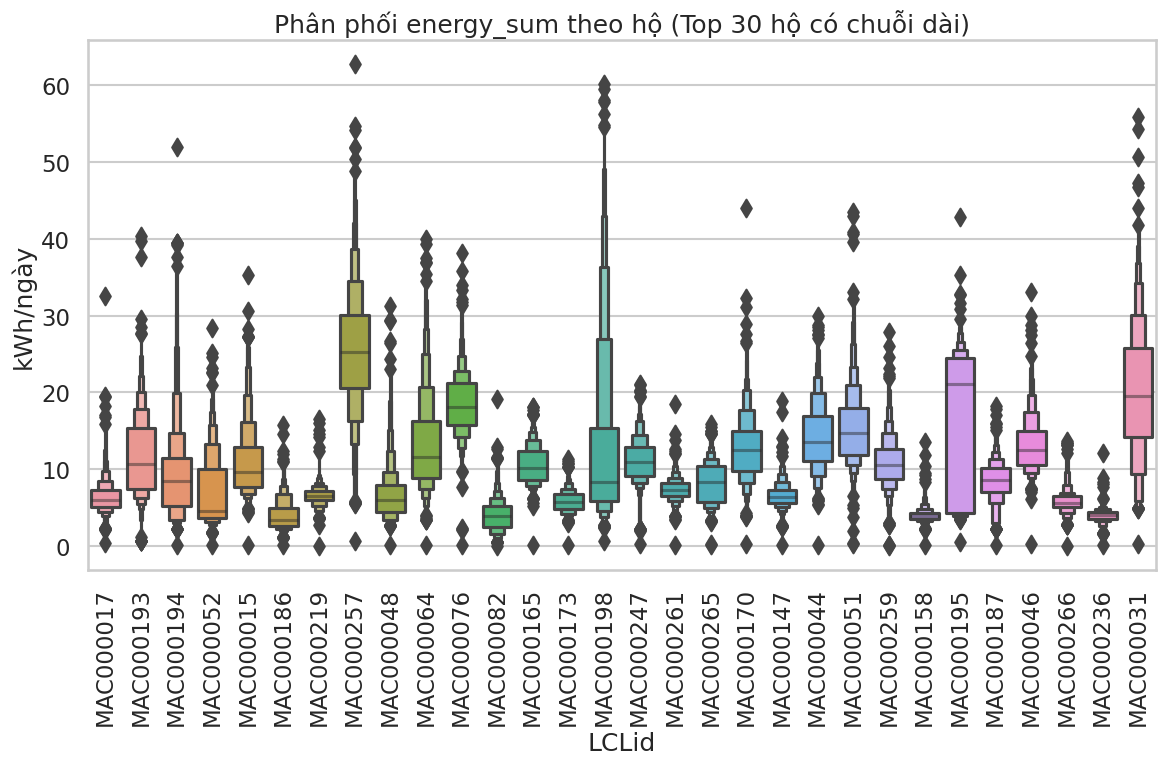

In [7]:
# ---------- 3) DISTRIBUTION of energy_sum ----------

# Histogram + KDE for overall distribution
plt.figure()
sns.histplot(df["energy_sum"], bins=50, kde=True)
plt.title("Distribution of daily energy_sum (kWh) – overall")
plt.xlabel("kWh per day"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Boxen plot for household-level variation (Top 30 households with longest records)
top_ids_30 = (
    df.groupby("LCLid")["day"].nunique()
      .sort_values(ascending=False).head(30).index.tolist()
)
plt.figure(figsize=(12,8))
sns.boxenplot(
    data=df[df["LCLid"].isin(top_ids_30)],
    x="LCLid", y="energy_sum"
)
plt.xticks(rotation=90)
plt.title("Distribution of energy_sum across households (Top 30)")
plt.xlabel("Household ID (LCLid)"); plt.ylabel("kWh per day")
plt.tight_layout(); plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

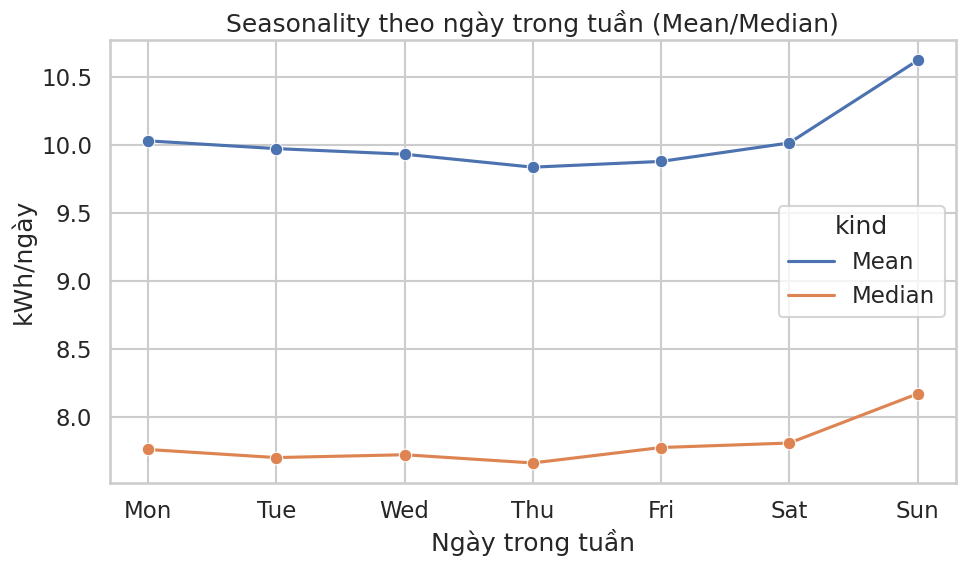

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


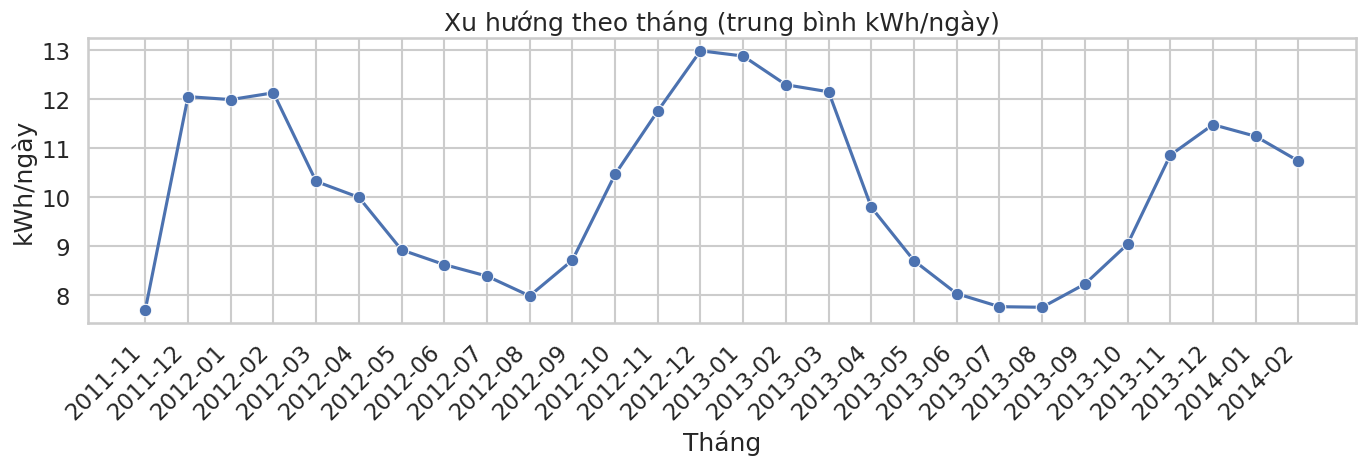

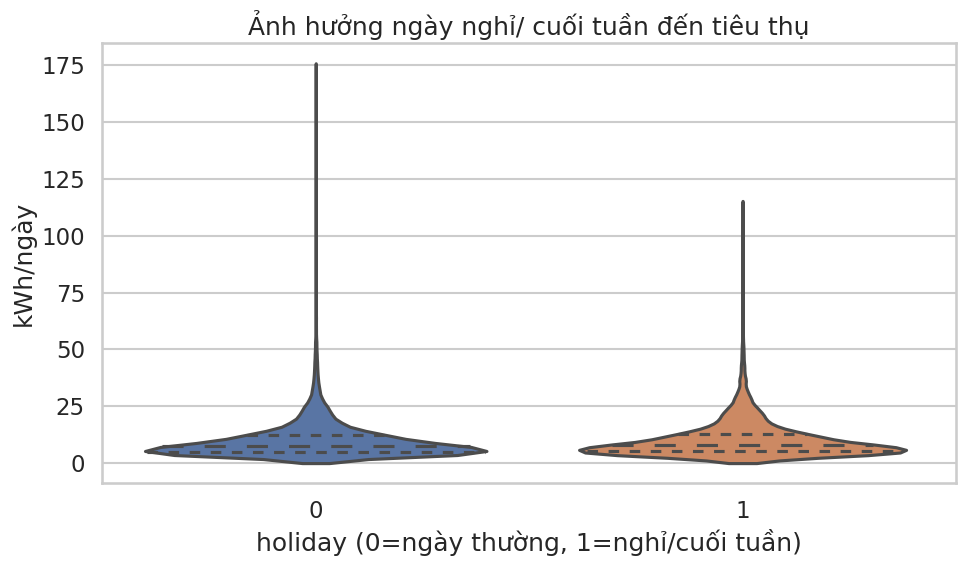

In [8]:
# ---------- 4) SEASONALITY: weekday & month ----------

# ---- Weekday pattern (mean vs median) ----
# Compute both mean and median consumption per weekday
wd = (df.groupby("weekday_name", as_index=False)["energy_sum"]
        .mean().assign(kind="Mean"))
wd_med = (df.groupby("weekday_name", as_index=False)["energy_sum"]
            .median().assign(kind="Median"))
wd_plot = pd.concat([wd, wd_med])

# Preserve weekday order Mon → Sun
wd_plot["weekday_order"] = wd_plot["weekday_name"].map(
    {k: i for i, k in enumerate(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])}
)
wd_plot = wd_plot.sort_values("weekday_order")

# Lineplot: mean vs median weekday consumption
plt.figure()
sns.lineplot(data=wd_plot, x="weekday_name", y="energy_sum", hue="kind", marker="o")
plt.title("Seasonality by weekday (Mean vs Median)")
plt.xlabel("Weekday"); plt.ylabel("kWh/day")
plt.tight_layout(); plt.show()

# ---- Monthly pattern ----
mstat = (df.groupby("month", as_index=False)["energy_sum"].mean())
plt.figure(figsize=(14,5))
sns.lineplot(data=mstat, x="month", y="energy_sum", marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Monthly trend of energy consumption (average kWh/day)")
plt.xlabel("Month"); plt.ylabel("kWh/day")
plt.tight_layout(); plt.show()

# ---- Holiday effect (if available) ----
if "holiday" in df.columns:
    plt.figure()
    sns.violinplot(data=df, x="holiday", y="energy_sum", cut=0, inner="quartile")
    plt.title("Impact of holidays/weekends on consumption")
    plt.xlabel("Holiday flag (0=weekday, 1=holiday/weekend)")
    plt.ylabel("kWh/day")
    plt.tight_layout(); plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


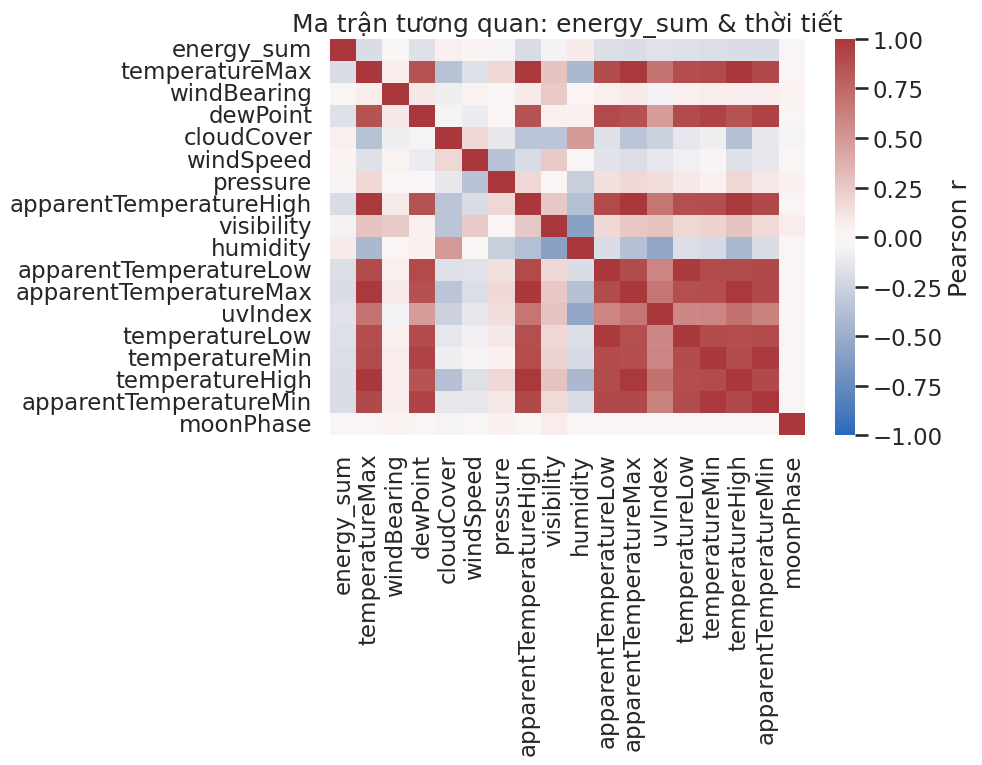

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

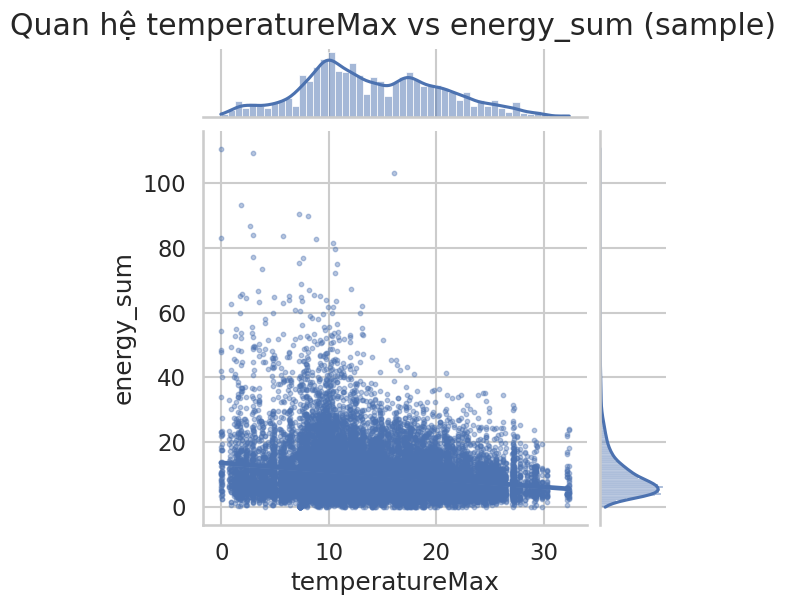

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

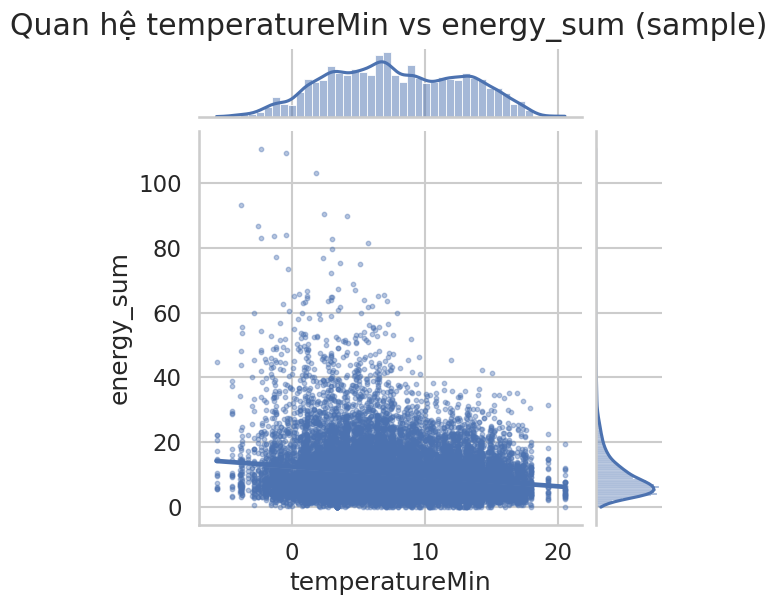

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

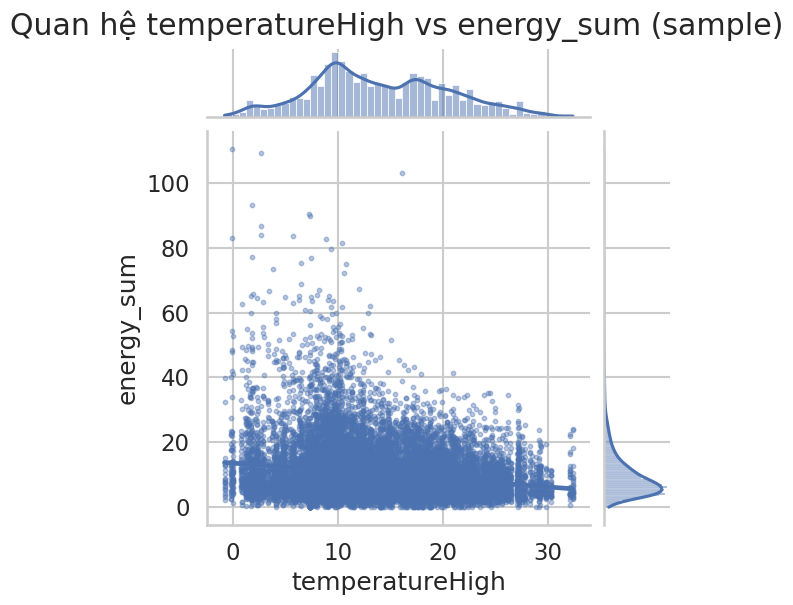

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

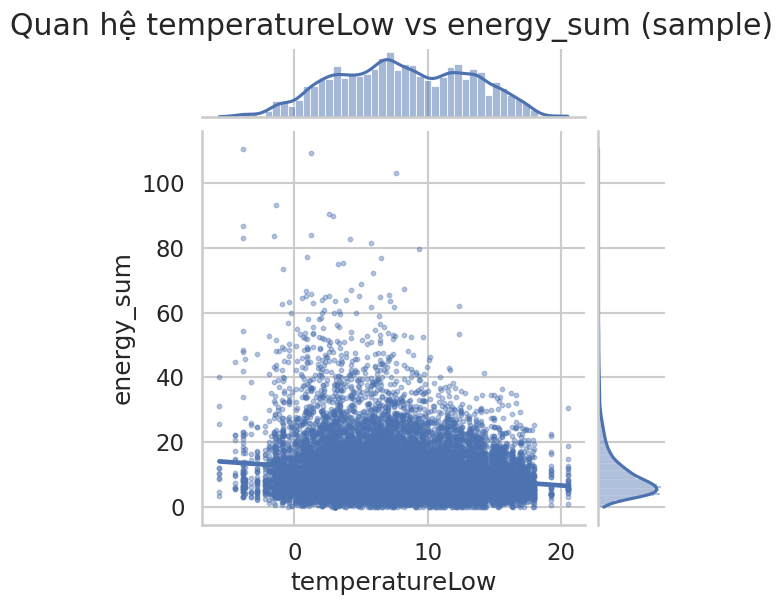

In [9]:
# ---------- 5) WEATHER RELATIONSHIPS ----------
if wcols:
    # ---- Correlation matrix between consumption and weather ----
    corr = df[["energy_sum"] + wcols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(
        corr, vmin=-1, vmax=1, annot=False, cmap="vlag", center=0,
        cbar_kws={"label":"Pearson r"}
    )
    plt.title("Correlation matrix: energy_sum & weather features")
    plt.tight_layout(); plt.show()

    # ---- Detailed scatter plots with regression lines ----
    # Example: relationship between daily energy consumption and temperature
    for tcol in ["temperatureMax","temperatureMin","temperatureHigh","temperatureLow"]:
        if tcol in df.columns:
            plt.figure()
            sns.jointplot(
                data=df.sample(min(len(df), 20000), random_state=42),
                x=tcol, y="energy_sum",
                kind="reg",
                scatter_kws={"s":10, "alpha":0.4}
            )
            plt.suptitle(f"Relationship: {tcol} vs energy_sum (sample)", y=1.02)
            plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


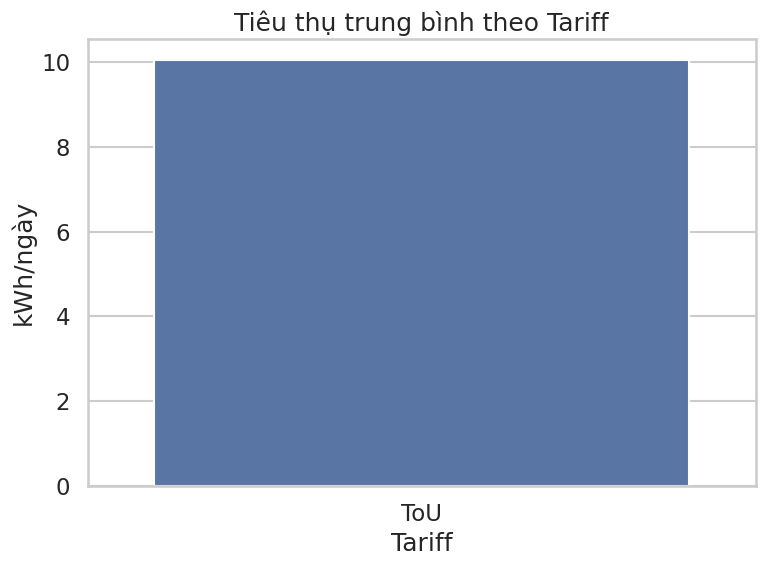

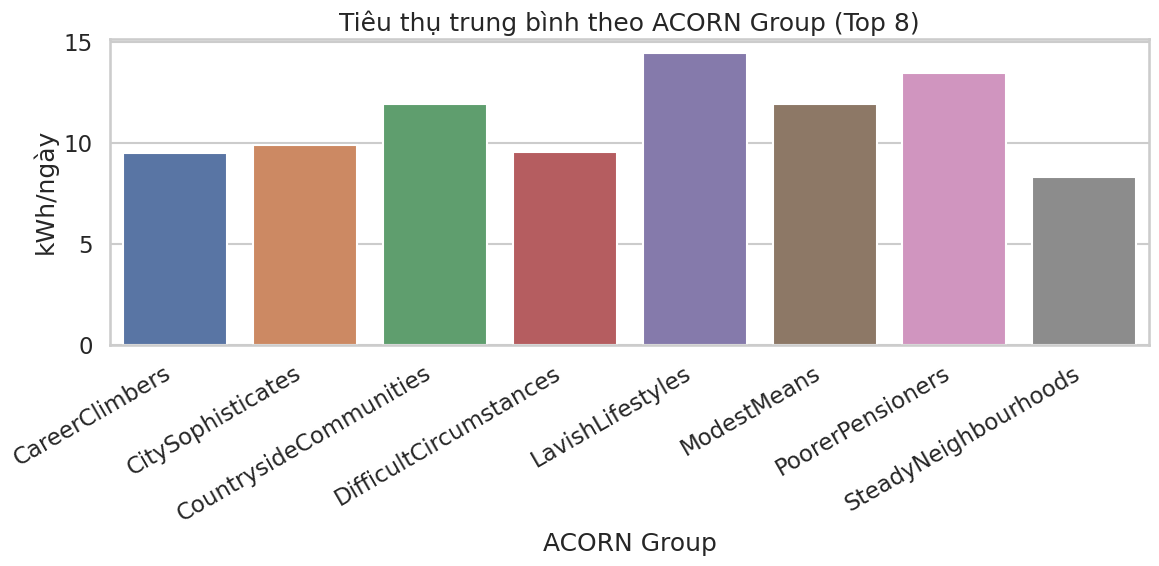

In [10]:
# ---------- 6) TARIFF & ACORN ----------
# ---- Average consumption by tariff type ----
if "Tariff" in df.columns:
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=(df.groupby("Tariff", as_index=False)["energy_sum"].mean()),
        x="Tariff", y="energy_sum"
    )
    plt.title("Average daily consumption by Tariff")
    plt.xlabel("Tariff"); plt.ylabel("kWh/day")
    plt.tight_layout(); plt.show()

# ---- Average consumption by ACORN socio-economic group ----
if "AcornGroup" in df.columns:
    # Keep only the top 8 most common groups for readability
    group_counts = df["AcornGroup"].value_counts()
    keep_groups = group_counts.head(8).index

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=(df[df["AcornGroup"].isin(keep_groups)]
                .groupby("AcornGroup", as_index=False)["energy_sum"].mean()),
        x="AcornGroup", y="energy_sum"
    )
    plt.title("Average daily consumption by ACORN Group (Top 8)")
    plt.xticks(rotation=30, ha="right")
    plt.xlabel("ACORN Group"); plt.ylabel("kWh/day")
    plt.tight_layout(); plt.show()


/tmp/ipykernel_19/1043408644.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lag_corr)


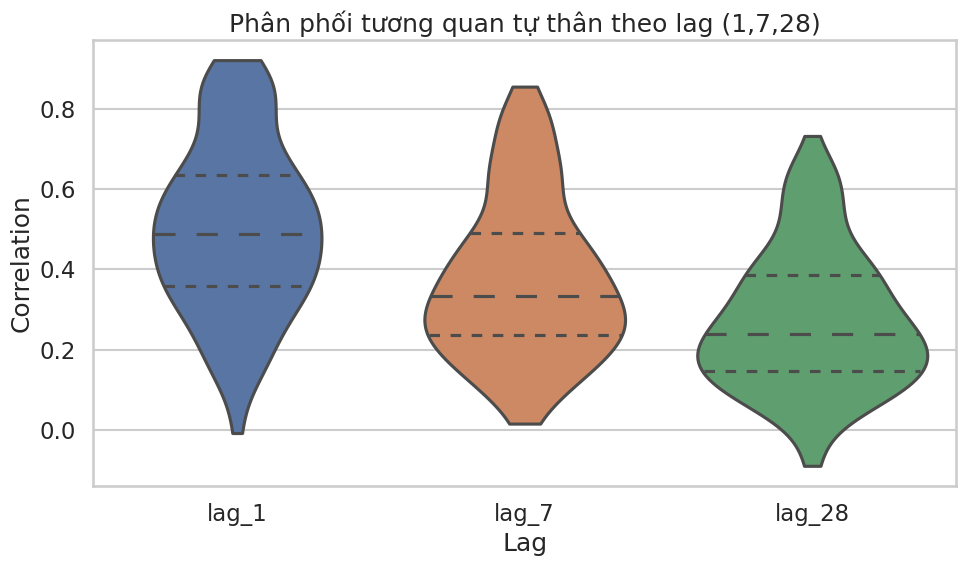

In [11]:
# ---------- 7) LAG RELATIONSHIPS ----------
# Function to compute Pearson correlation between energy_sum and its lagged values
def lag_corr(g, lags=(1,7,28)):
    s = g.sort_values("day")["energy_sum"].reset_index(drop=True)
    out = {}
    for L in lags:
        if len(s) > L:
            out[f"lag_{L}"] = s.corr(s.shift(L))  # correlation with lag L
        else:
            out[f"lag_{L}"] = np.nan
    return pd.Series(out)

# Compute lag correlations for each household (group by LCLid)
lag_df = (
    df.groupby("LCLid")
      .apply(lag_corr)
      .reset_index()
)

# Convert wide → long format for plotting
lag_long = lag_df.melt(id_vars="LCLid", var_name="lag", value_name="corr")

# Visualization: distribution of correlations for lag 1, 7, 28
plt.figure()
sns.violinplot(data=lag_long, x="lag", y="corr", cut=0, inner="quartile")
plt.title("Distribution of autocorrelation by lag (1, 7, 28)")
plt.xlabel("Lag"); plt.ylabel("Correlation")
plt.tight_layout(); plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

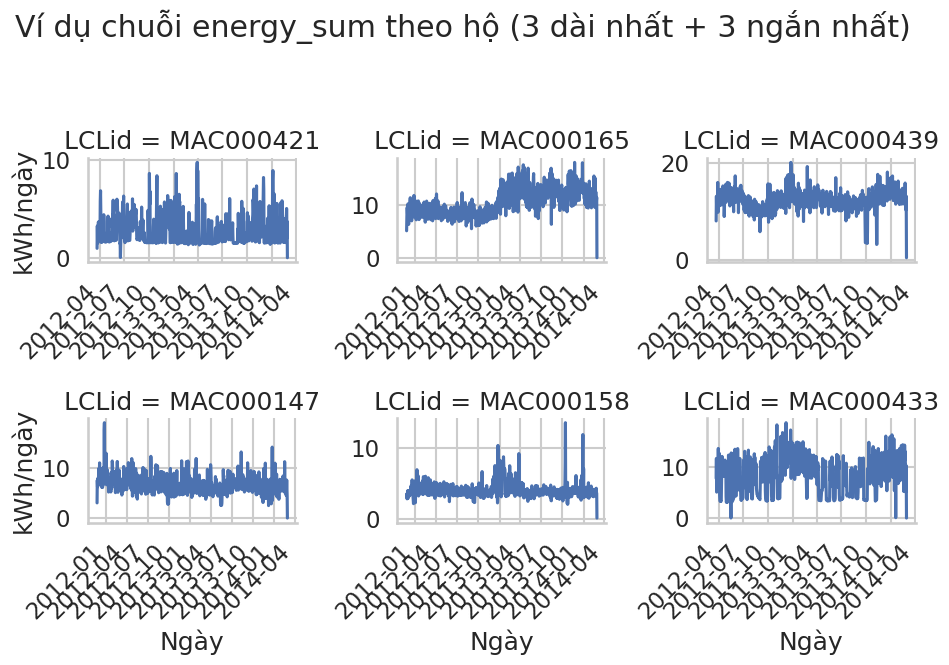

EDA Hoàn tất.


In [12]:
# ---------- 8) EXAMPLE SERIES ----------
# Select 6 representative households:
#   - 3 with the longest daily records
#   - 3 with the shortest daily records (within the 169 subset)
by_len = df.groupby("LCLid")["day"].nunique().sort_values(ascending=False)
ex_ids = list(by_len.head(3).index) + list(by_len.tail(3).index)

# FacetGrid: plot each selected household in its own panel
g = sns.FacetGrid(
    data=df[df["LCLid"].isin(ex_ids)],
    col="LCLid", col_wrap=3, sharex=False, sharey=False, height=3.2
)
g.map_dataframe(sns.lineplot, x="day", y="energy_sum")
g.set_axis_labels("Date", "kWh/day")
g.fig.suptitle("Example household series (3 longest + 3 shortest records)", y=1.05)

# Format x-axis as year-month and rotate labels
for ax in g.axes.flatten():
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    for label in ax.get_xticklabels():
        label.set_rotation(45); label.set_ha("right")

plt.tight_layout(); plt.show()

print("EDA Completed.")

In [13]:
# ========= 0) READ & BASIC CLEAN =========
import os, math, numpy as np, pandas as pd
from pathlib import Path

DF_PATH = Path("/kaggle/working/finaldf_169.csv")
df = pd.read_csv(DF_PATH, low_memory=False)

# Ensure required columns exist
required = {"day","LCLid","energy_sum"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

# Normalize date and drop rows missing key fields
df["day"] = pd.to_datetime(df["day"], errors="coerce")
df = df.dropna(subset=["day","LCLid","energy_sum"]).copy()

# ========= 1) GLOBAL TIME INDEX =========
# Build a global continuous time index across all households
date_map = (
    df[["day"]].drop_duplicates().sort_values("day").reset_index(drop=True)
    .rename_axis("time_idx").reset_index()
)
date_map["time_idx"] = date_map["time_idx"] + 1  # start at 1
df = df.merge(date_map, on="day", how="left").sort_values(["LCLid","time_idx"])

# ========= 2) CLEAN CATEGORICALS =========
# Strip/standardize string categories; backfill missing Acorn columns as "Unknown"
for col in ["AcornGroup","AcornCategory","LCLid"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().replace({"nan":"Unknown","None":"Unknown"})
for col in ["AcornGroup","AcornCategory"]:
    if col not in df.columns:
        df[col] = "Unknown"

# ========= 3) WEATHER COLUMNS (use all available) =========
weather_cols_all = [
    "temperatureMax","windBearing","dewPoint","cloudCover","windSpeed","pressure",
    "apparentTemperatureHigh","visibility","humidity","apparentTemperatureLow",
    "apparentTemperatureMax","uvIndex","temperatureLow","temperatureMin",
    "temperatureHigh","apparentTemperatureMin","moonPhase"
]
wcols = [c for c in weather_cols_all if c in df.columns]

if wcols:
    # Collapse to one daily row and sort by date
    weather_daily = (
        df[["day"] + wcols]
        .groupby("day", as_index=True).first().sort_index()
    )
    # Time interpolation for gaps + median fill as fallback
    weather_daily[wcols] = weather_daily[wcols].interpolate(method="time", limit_direction="both")
    for c in wcols:
        if weather_daily[c].isna().any():
            weather_daily[c] = weather_daily[c].fillna(weather_daily[c].median())
    # Merge back only the imputed weather columns
    df = df.drop(columns=wcols, errors="ignore").merge(
        weather_daily[wcols].reset_index(), on="day", how="left"
    )

# ========= 4) SPLITS =========
# Rolling scheme: train | val(28d) | test(28d)
H = 28  # 7 for week, 28 for ~month
last_idx = int(df["time_idx"].max())
train_cutoff = last_idx - 2*H
val_end      = train_cutoff + H
test_end     = last_idx  # == train_cutoff + 2H
print({"train_cutoff": train_cutoff, "val_end": val_end, "test_end": test_end})

# ========= 5) TFT DATASET =========
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Known real-valued covariates fed to encoder/decoder
known_reals = ["time_idx"]
if "holiday" in df.columns:
    df["holiday"] = pd.to_numeric(df["holiday"], errors="coerce").fillna(0).astype(np.float32)
    known_reals.append("holiday")
known_reals += [c for c in weather_cols_all if c in df.columns]
known_reals += [c for c in df.columns if c.endswith("_was_missing")]

# Candidate categoricals in addition to group id
cat_candidates = [c for c in ["AcornGroup","AcornCategory"] if c in df.columns]

# Utility: a column is static if each LCLid has a single unique value
def is_static_by_group(col):
    nun = df.groupby("LCLid")[col].nunique(dropna=False)
    return nun.max() == 1

# Split categorical features into static vs time-varying known
static_categoricals = ["LCLid"]  # per-household embeddings
time_varying_known_categoricals = []
for c in cat_candidates:
    if is_static_by_group(c):
        static_categoricals.append(c)
    else:
        time_varying_known_categoricals.append(c)

# Unknown reals: the target only
time_varying_unknown_reals = ["energy_sum"]

# Label encoders for all categorical features
categorical_encoders = {
    c: NaNLabelEncoder(add_nan=True)
    for c in (static_categoricals + time_varying_known_categoricals)
}

# Sequence lengths
max_prediction_length = H
max_encoder_length    = 168  # ~6 months context

# Split frames by global time index
df_train = df[df["time_idx"] <= train_cutoff].copy()
df_val   = df[df["time_idx"] <= val_end].copy()
df_test  = df[df["time_idx"] <= test_end].copy()

# Build TimeSeriesDataSet with lags and helper encodings
training_dataset = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="energy_sum",
    group_ids=["LCLid"],

    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    static_categoricals=static_categoricals,
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,

    categorical_encoders=categorical_encoders,

    target_normalizer=GroupNormalizer(groups=["LCLid"], transformation="softplus"),

    lags={"energy_sum": [7, 28]},  # add 365 if sequence length allows

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,

    allow_missing_timesteps=True,
)

# Clone datasets for validation/test (same schema)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_val, predict=True, stop_randomization=True
)
test_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_test, predict=True, stop_randomization=True
)

print(
    "series:", df["LCLid"].nunique(),
    "| time_idx:", int(df["time_idx"].min()), "→", int(df["time_idx"].max()),
    "\nstatic_categoricals:", static_categoricals,
    "\ntime_varying_known_categoricals:", time_varying_known_categoricals,
    "\nknown_reals:", known_reals,
)

# ========= 6) DATALOADERS =========
BATCH_SIZE = 128
NUM_WORKERS = 2  # bump to 3–4 if the machine is stable

train_dataloader = training_dataset.to_dataloader(
    train=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, batch_size=BATCH_SIZE*4, num_workers=NUM_WORKERS, drop_last=False
)
test_dataloader = test_dataset.to_dataloader(
    train=False, batch_size=BATCH_SIZE*4, num_workers=NUM_WORKERS, drop_last=False
)

# ========= 7) MODEL & TRAIN =========
import lightning as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import torch

pl.seed_everything(42, workers=True)

SAVE_DIR = os.getenv("SAVE_DIR", "/kaggle/working/tft_logs")
os.makedirs(SAVE_DIR, exist_ok=True)

# Early stopping, LR monitor, and best-checkpoint saver
callbacks = [
    EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, mode="min"),
    LearningRateMonitor(logging_interval="epoch"),
    ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="tft-{epoch:02d}-{val_loss:.4f}")
]
logger = TensorBoardLogger(save_dir=SAVE_DIR, name="tft")

# Instantiate TFT from dataset metadata
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.2,
    hidden_continuous_size=160,
    output_size=7,              # number of quantiles
    loss=QuantileLoss(),        # pinball loss for probabilistic forecasts
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Params: {tft.size()/1e3:.1f}k")

# Lightning trainer
trainer = pl.Trainer(
    max_epochs=45,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=1.0,
    log_every_n_steps=10,
    callbacks=callbacks,
    logger=logger,
)


{'train_cutoff': 773, 'val_end': 801, 'test_end': 829}


INFO: Seed set to 42


series: 169 | time_idx: 1 → 829 
static_categoricals: ['LCLid', 'AcornGroup', 'AcornCategory'] 
time_varying_known_categoricals: [] 
known_reals: ['time_idx', 'holiday', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase']


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


Params: 4251.5k


In [14]:
# Kick off training with the configured callbacks/loggers:
# - uses GPU if available (per Trainer config)
# - optimizes up to 45 epochs with gradient clipping (0.1)
# - evaluates on val_dataloader each epoch
# - EarlyStopping monitors `val_loss` (patience=10)
# - ModelCheckpoint saves the best ckpt by lowest `val_loss`
# - LearningRateMonitor logs LR schedule to TensorBoard
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


2025-09-27 15:34:09.517350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758987249.701140      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758987249.750443      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best ckpt: /kaggle/working/tft_logs/tft/version_0/checkpoints/tft-epoch=00-val_loss=1.5736.ckpt


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 💡 Tip: For seamless cloud uploads and versioning, try install

Validation MAE: 2.893453


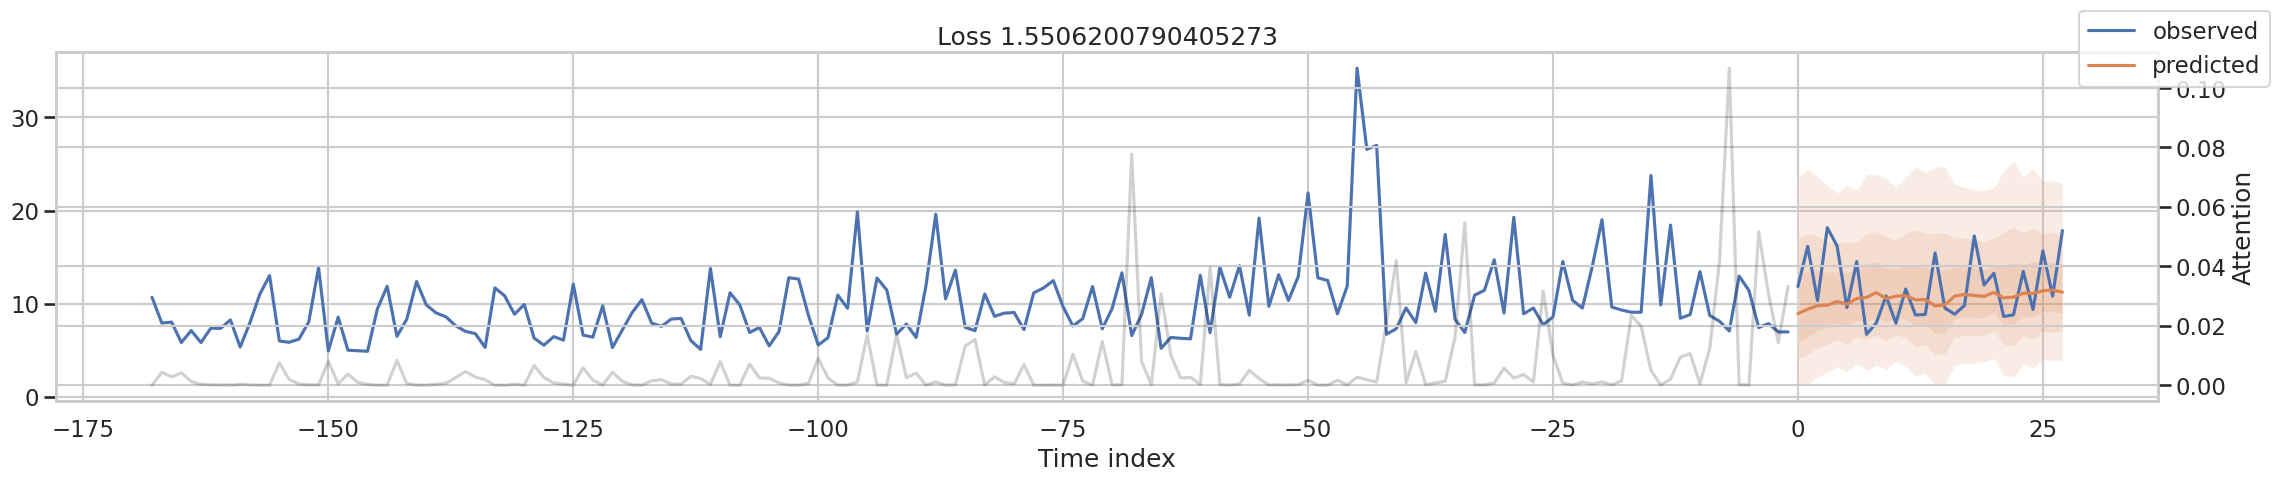

In [15]:
# =========================
# 1) Load best checkpoint
# =========================
best_model_path = trainer.checkpoint_callback.best_model_path
print("Best ckpt:", best_model_path)

# Load lại mô hình TFT tốt nhất từ checkpoint đã lưu
# (cảnh báo về 'loss' và 'logging_metrics' có thể bỏ qua)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


# =========================
# 2) Validation MAE
# =========================
import torch, numpy as np, math

# Lấy ground truth từ val_dataloader (flatten thành vector 1 chiều)
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)]).reshape(-1).cpu()

# Lấy dự báo từ mô hình (mode="prediction") và ép về numpy trên CPU
val_prediction_results = best_tft.predict(val_dataloader, mode="prediction")
if isinstance(val_prediction_results, torch.Tensor):
    preds_cpu_np = val_prediction_results.detach().cpu().numpy().reshape(-1)
else:
    preds_cpu_np = np.asarray(val_prediction_results).reshape(-1)

# Chuyển predictions sang tensor để tính toán đồng nhất
preds_t = torch.from_numpy(preds_cpu_np)

# Tính MAE thủ công cho validation
val_mae = torch.mean(torch.abs(actuals - preds_t)).item()
print(f"Validation MAE: {val_mae:.6f}")


# =========================
# 3) Raw predictions + plot attention
# =========================
import matplotlib.pyplot as plt

# Lấy dự báo raw cùng input để có thể vẽ attention
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Hỗ trợ cả 2 kiểu output (object hoặc dict)
x_inp   = getattr(val_prediction_results, "x",      None)
output  = getattr(val_prediction_results, "output", None)
if x_inp is None and isinstance(val_prediction_results, dict):
    x_inp  = val_prediction_results["x"]
    output = val_prediction_results["output"]

# Vẽ thử 1 mẫu dự báo từ validation với attention visualization
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(
        x_inp,                 # network input
        output,                # network output
        idx=idx,               # chỉ số sample
        add_loss_to_title=True,
        ax=ax
    )
    plt.show()


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[INFO] Có thể vẽ 27/29 features. Ví dụ: ['encoder_length', 'energy_sum_center', 'energy_sum_scale', 'time_idx', 'holiday', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed']


/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:2218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[Static variables - top 10]
[('LCLid', 90.83602142333984), ('AcornCategory', 31.380294799804688), ('AcornGroup', 8.720183372497559)]

[Encoder variables (time-varying) - top 10]
[('time_idx', 23.15980339050293), ('energy_sum', 11.54623031616211), ('uvIndex', 8.47435188293457), ('dewPoint', 5.513516426086426), ('temperatureMax', 5.507355690002441), ('pressure', 5.40693998336792), ('temperatureLow', 5.230170726776123), ('temperatureMin', 5.2287492752075195), ('apparentTemperatureMax', 5.192834854125977), ('temperatureHigh', 4.801850318908691)]

[Decoder variables (time-varying future-known) - top 10]
[('temperatureHigh', 18.80681610107422), ('pressure', 13.033794403076172), ('holiday', 11.50331974029541), ('humidity', 11.462081909179688), ('windBearing', 11.423324584960938), ('moonPhase', 11.297292709350586), ('windSpeed', 10.495895385742188), ('time_idx', 10.305513381958008), ('visibility', 9.693609237670898), ('cloudCover', 9.108899116516113)]


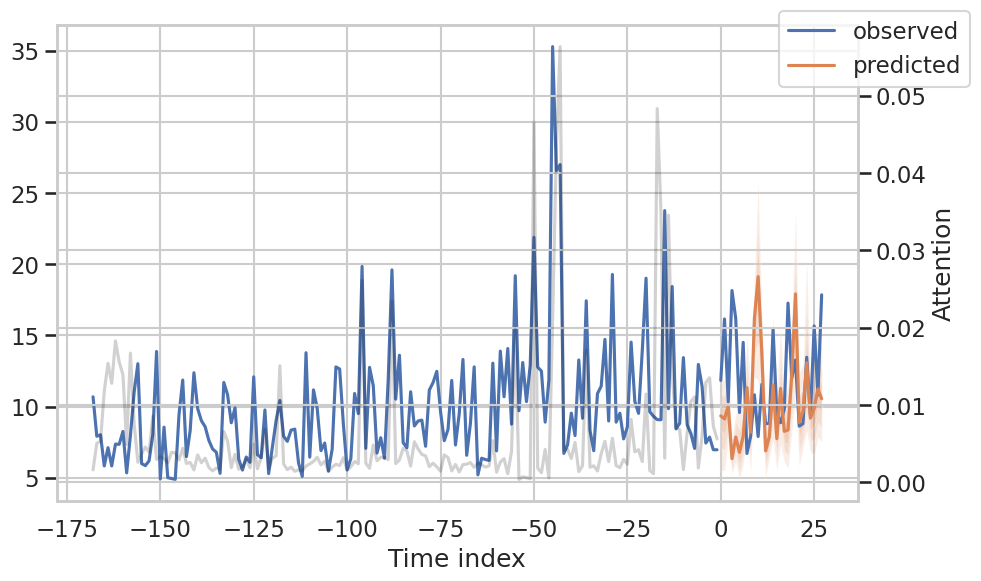

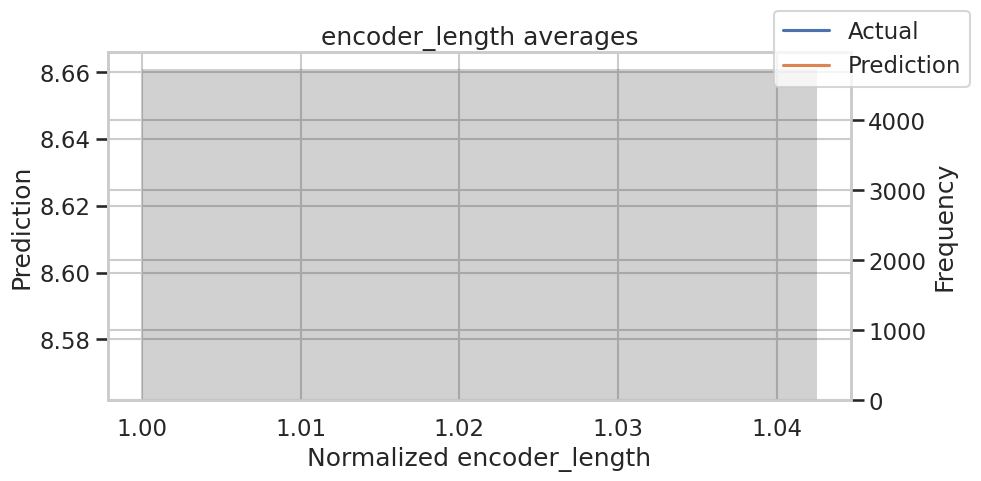

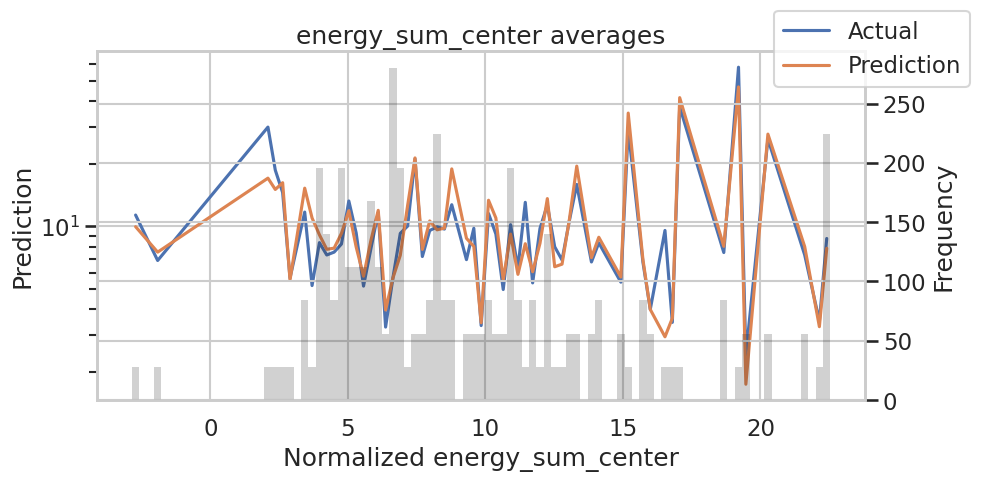

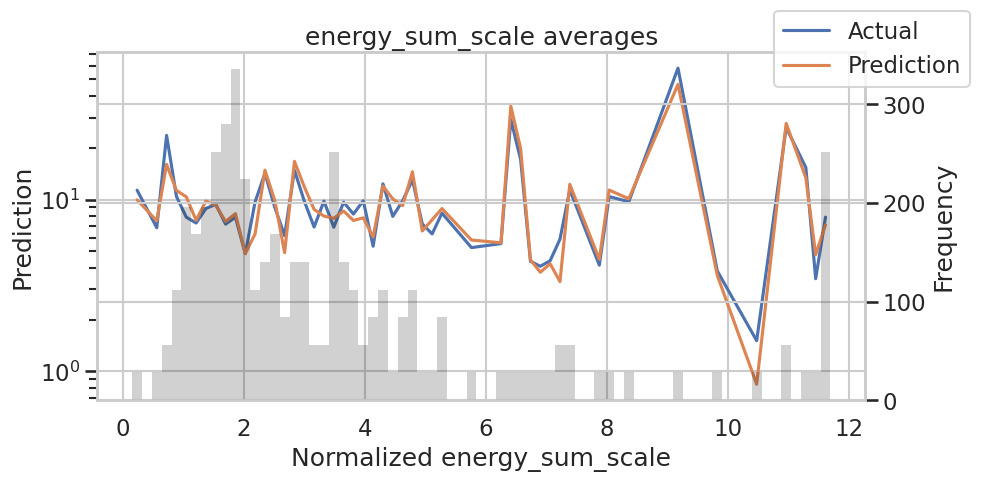

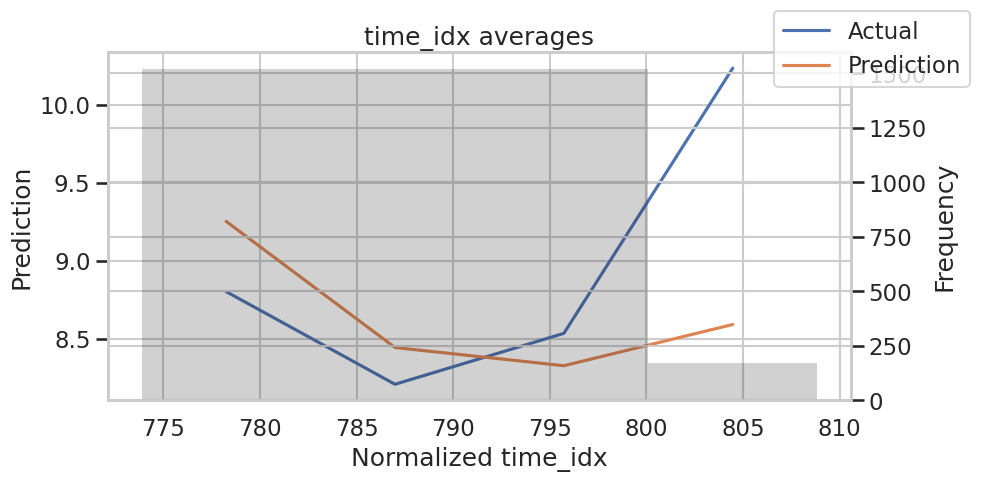

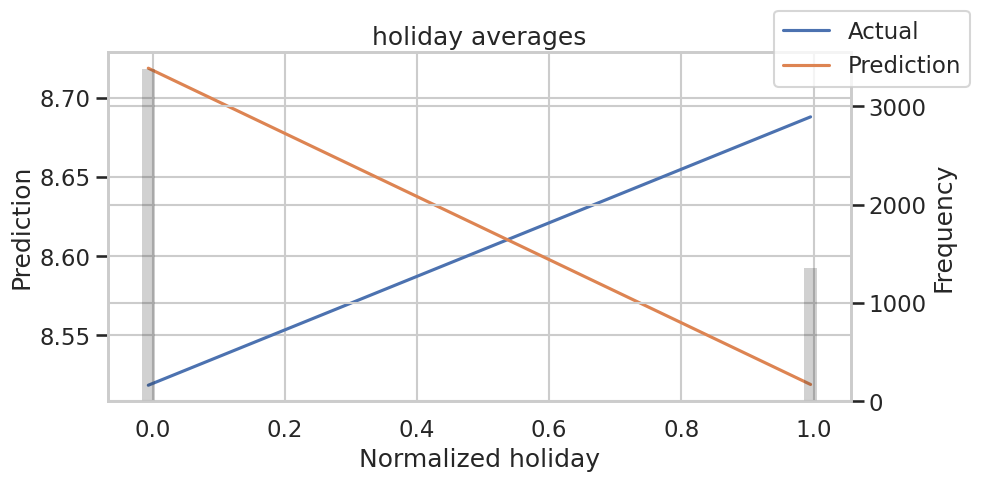

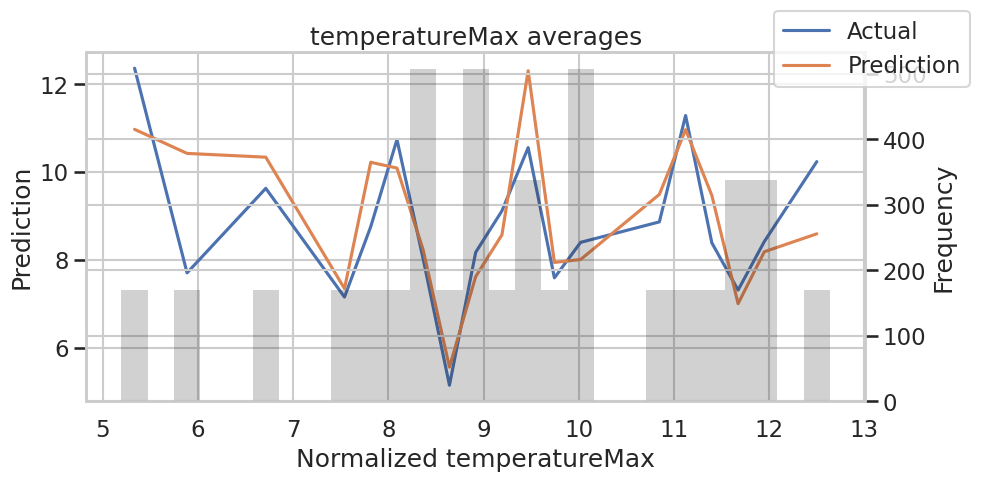

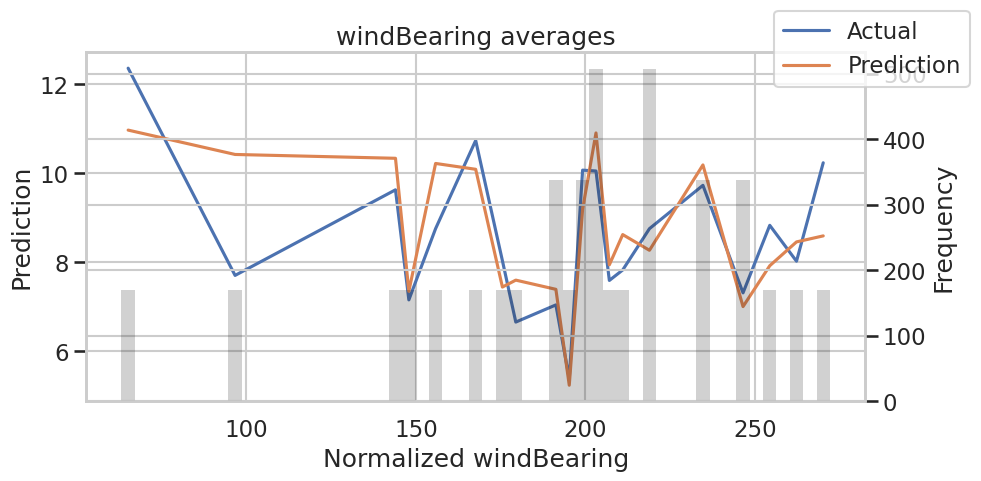

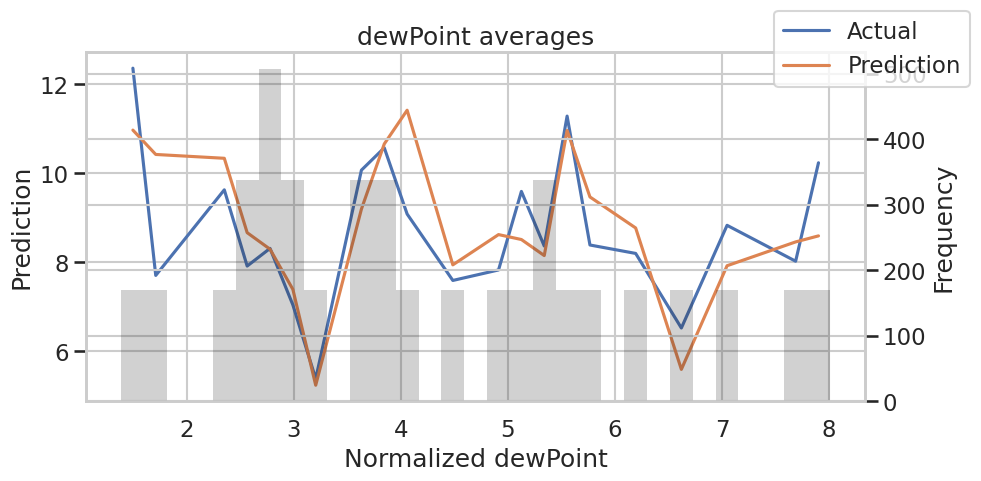

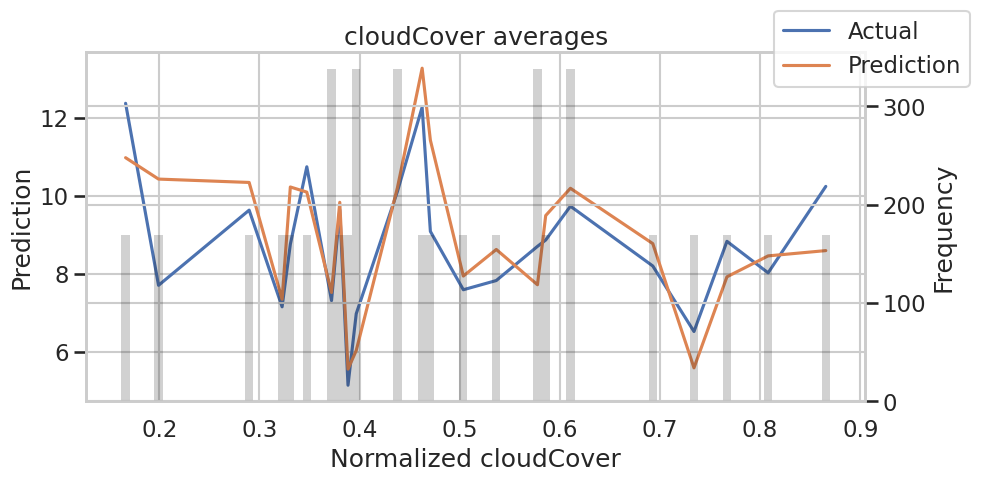

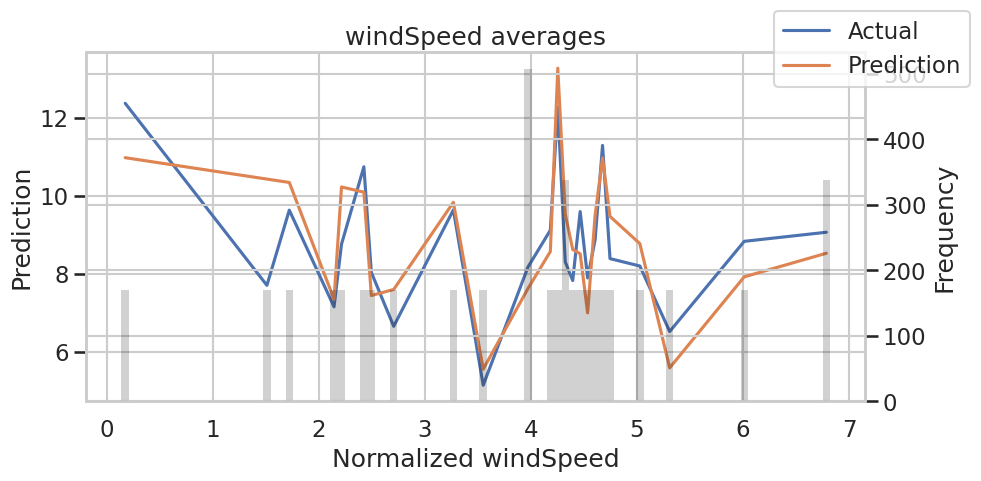

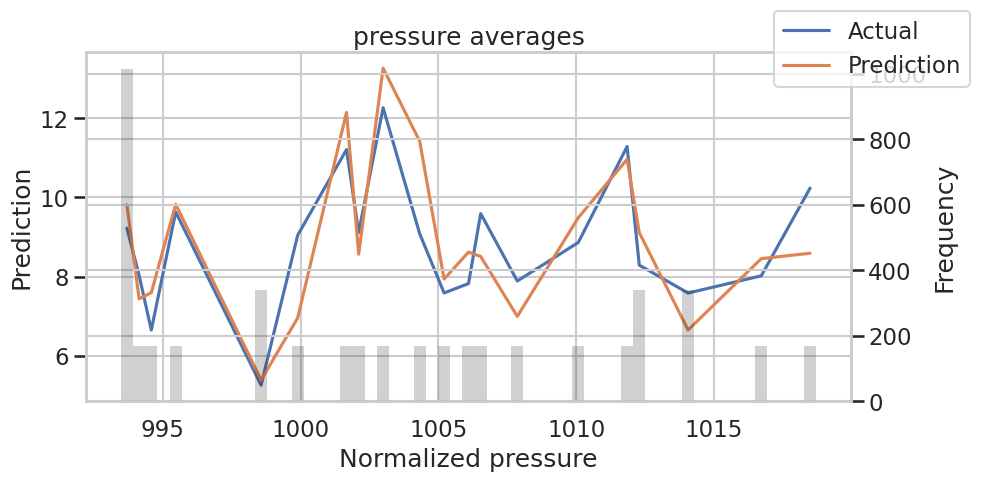

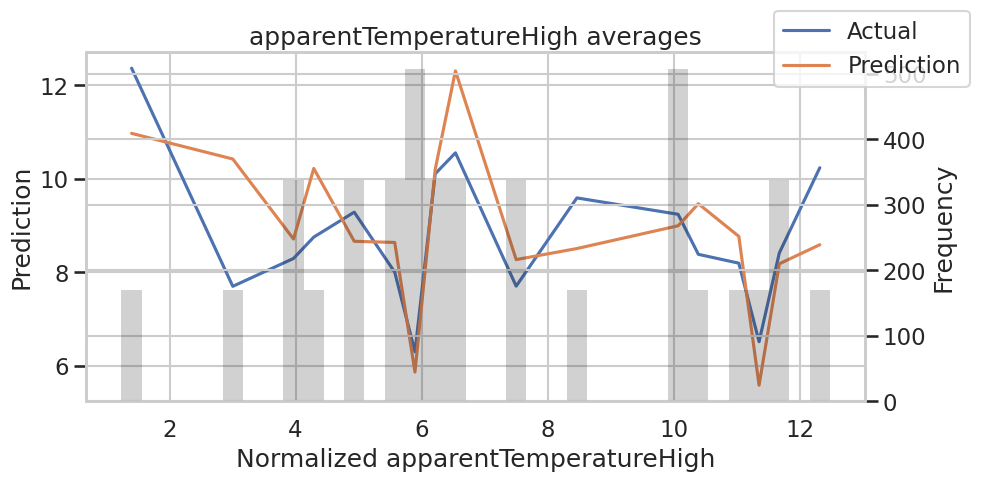

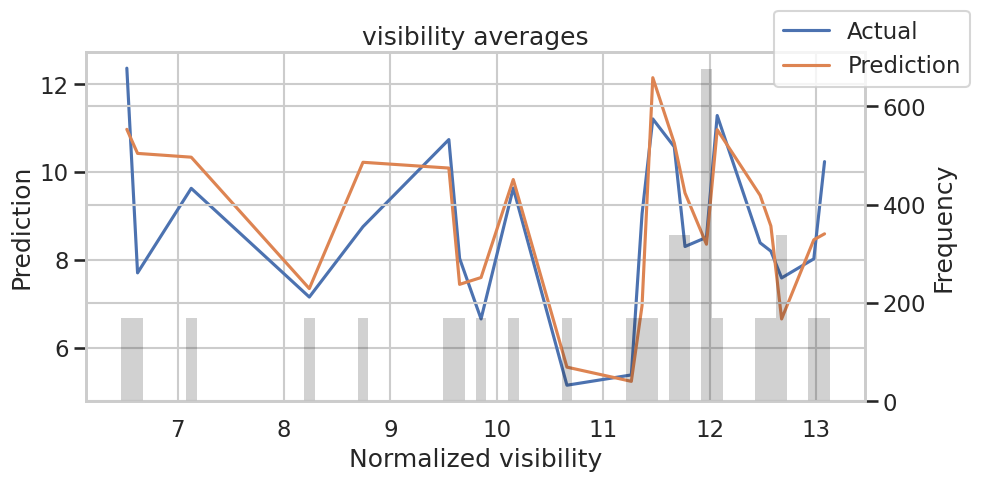

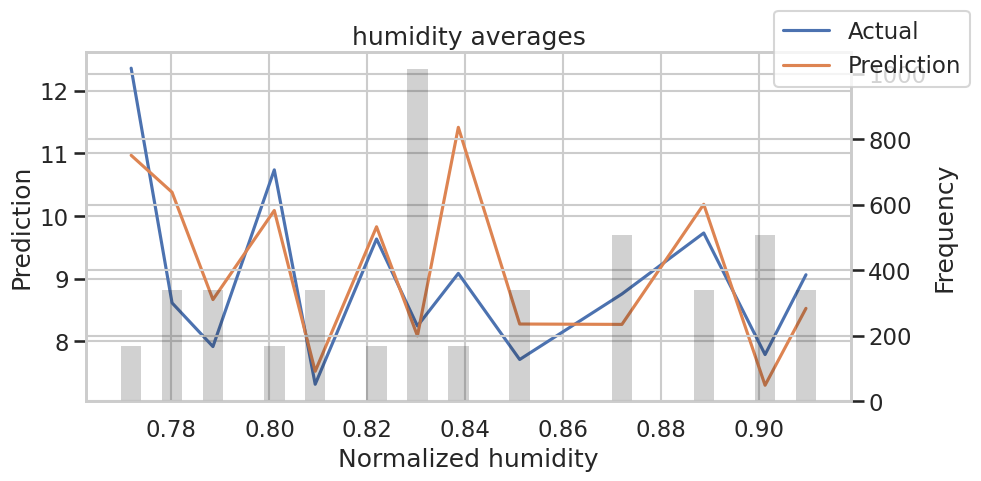

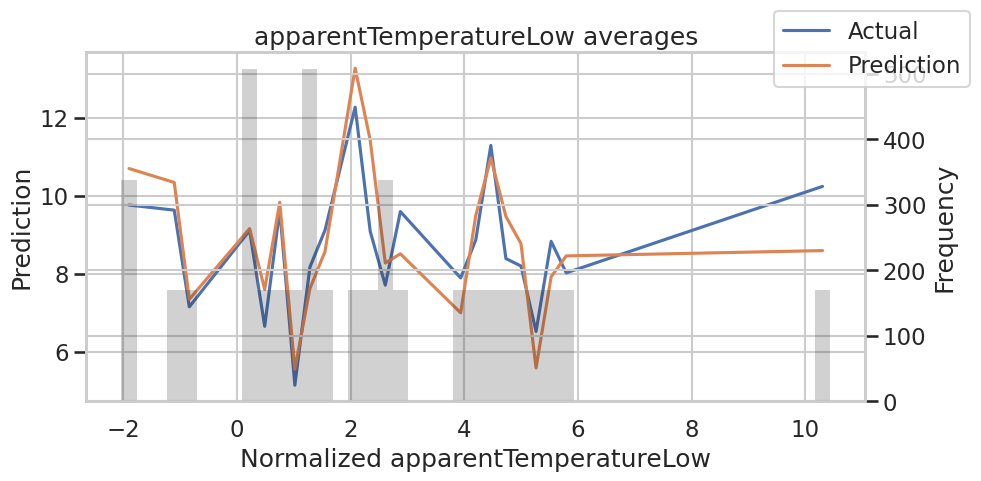

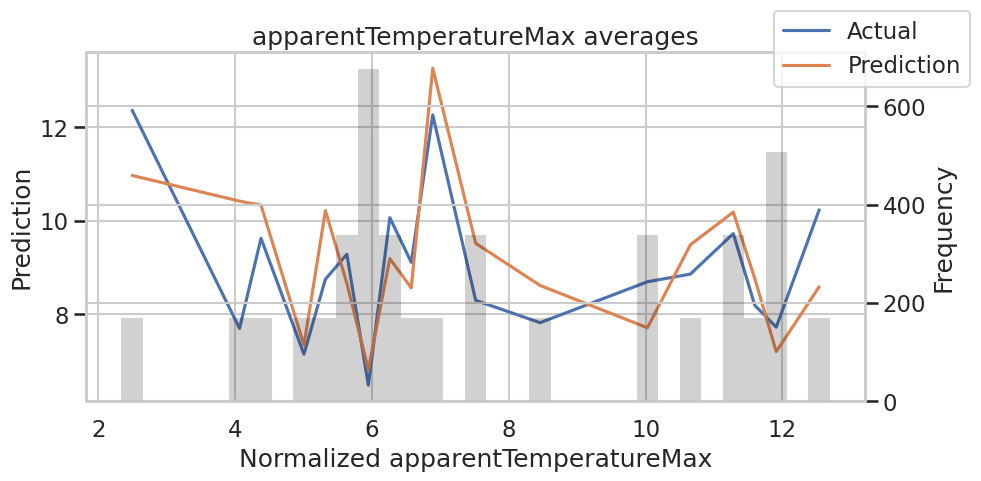

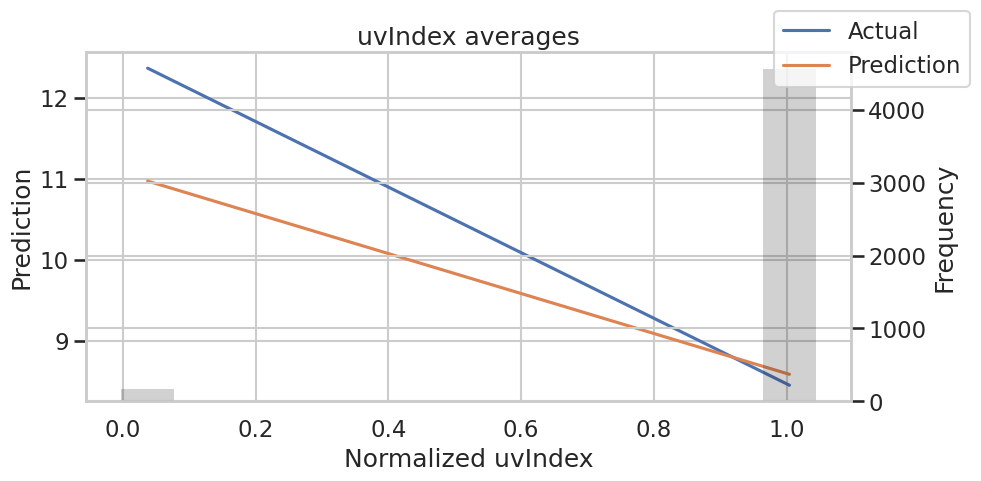

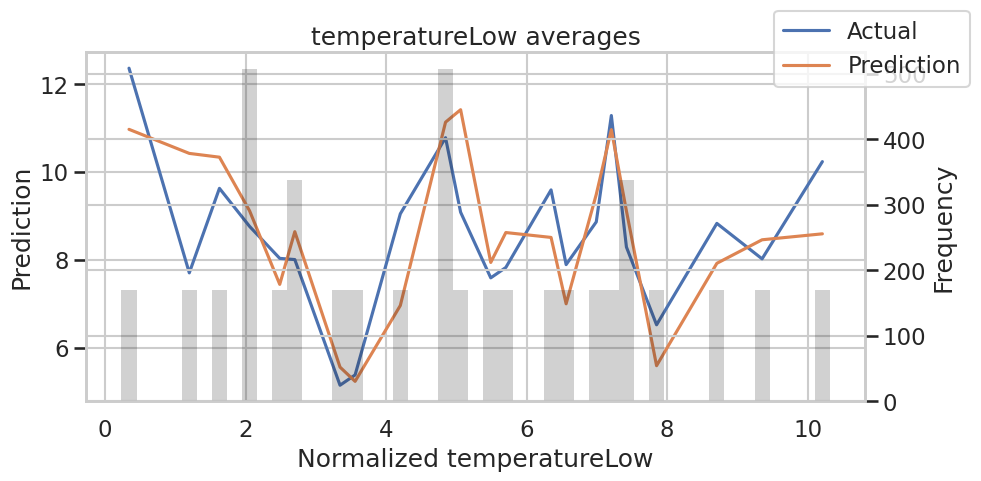

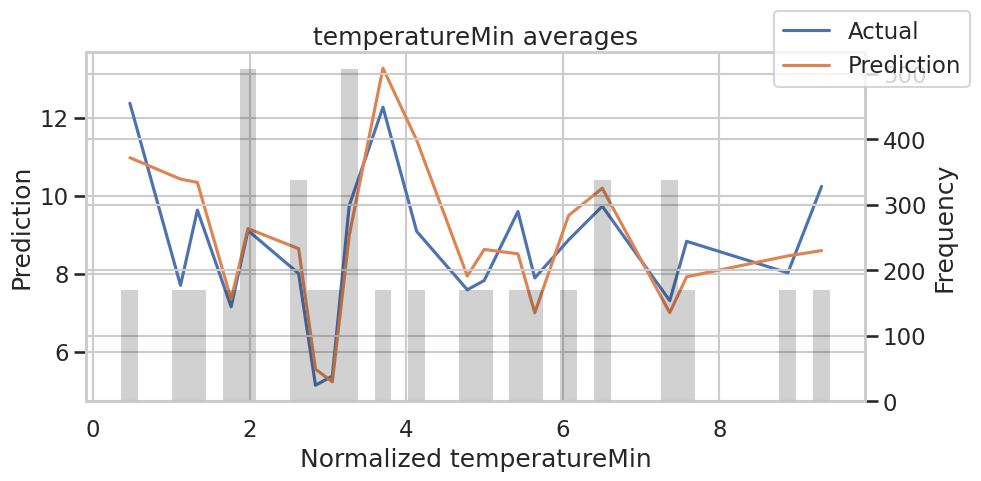

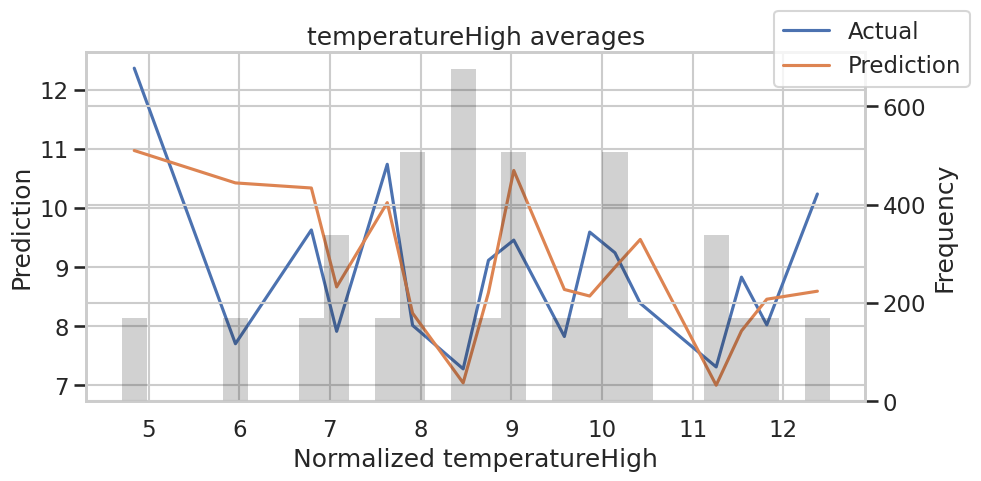

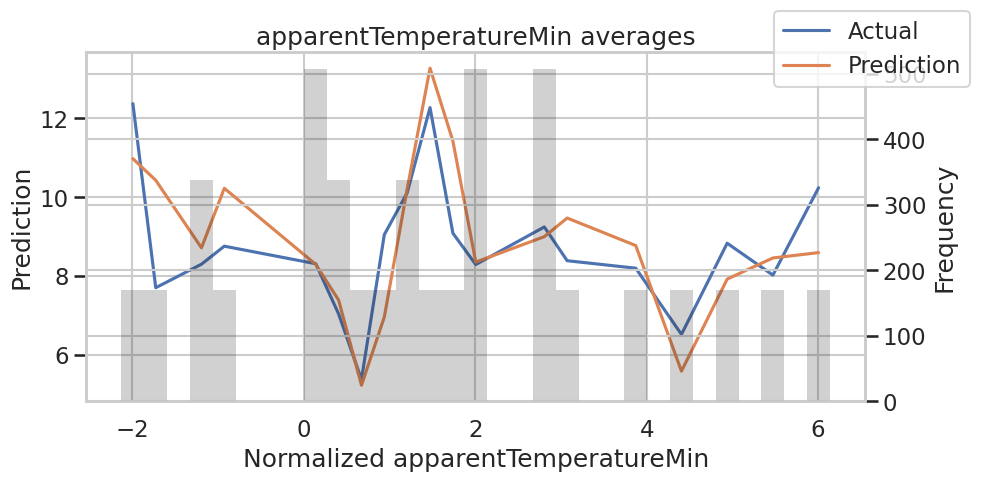

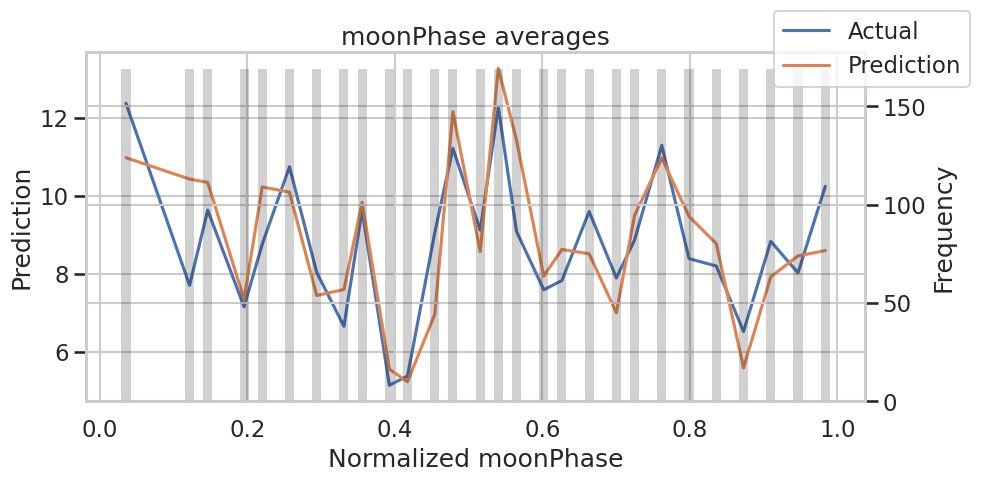

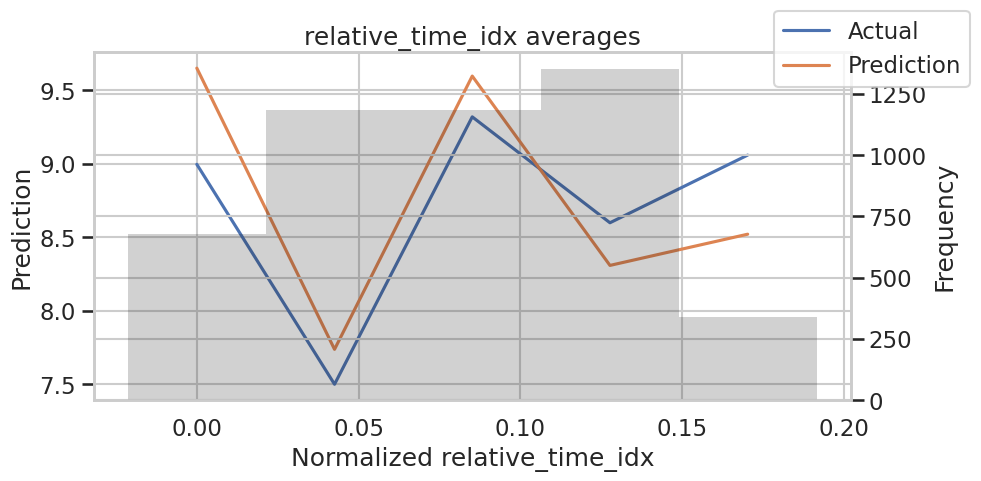

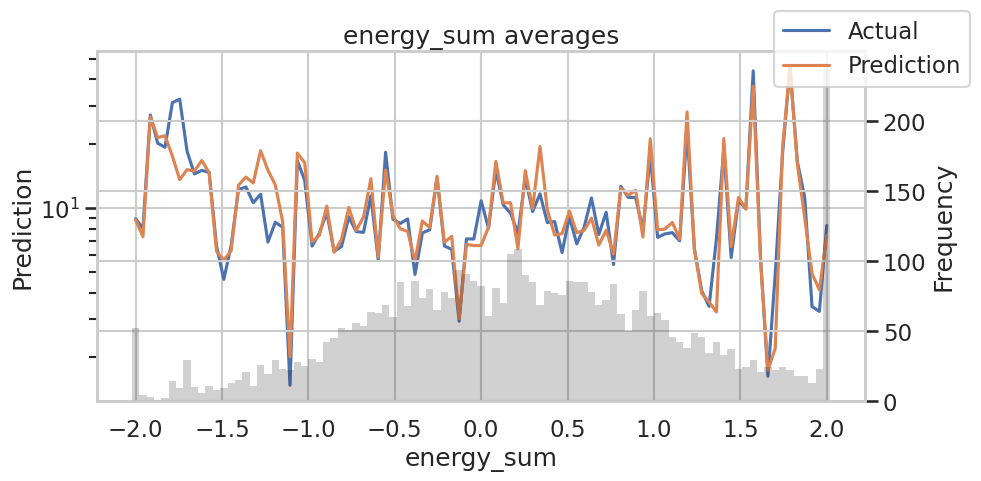

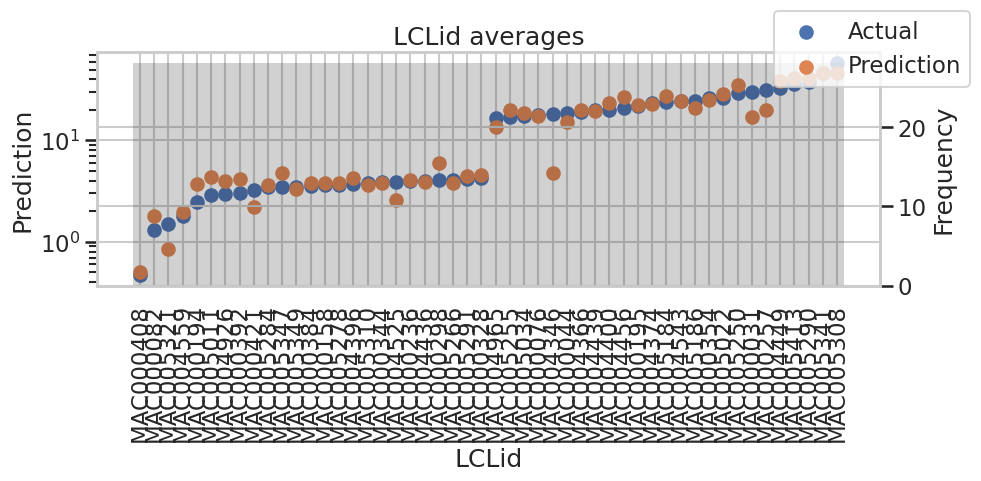

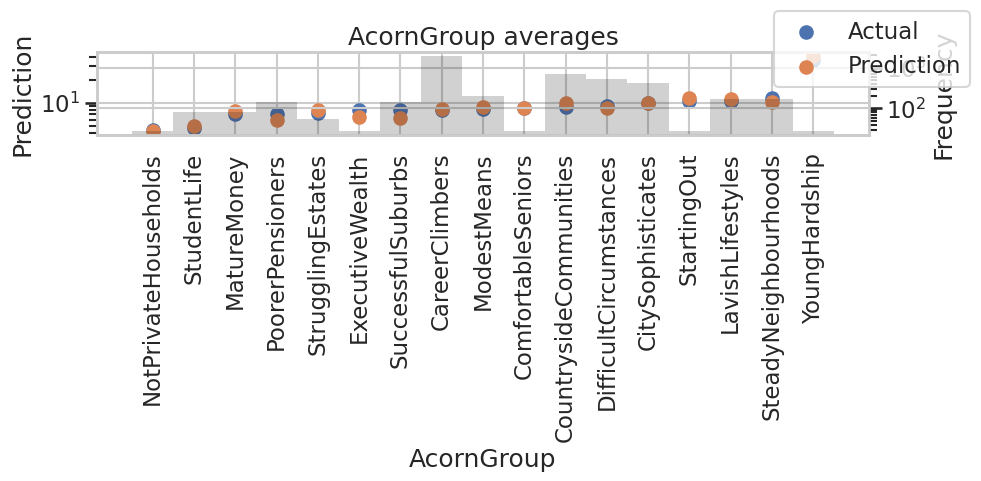

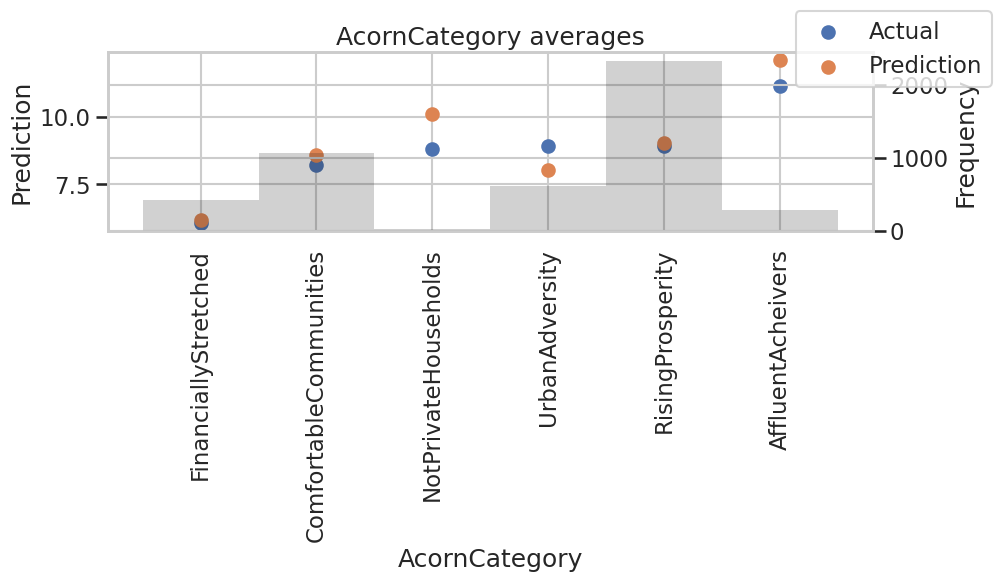

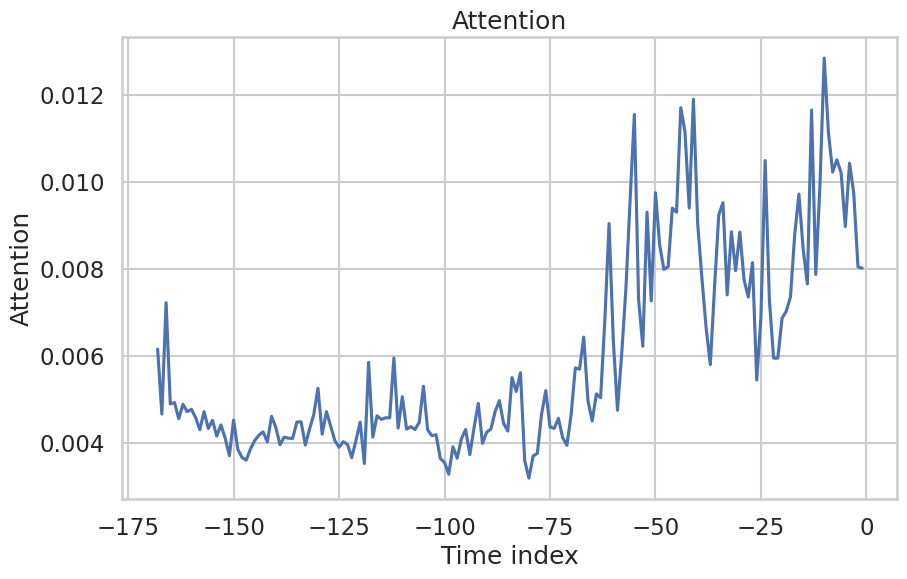

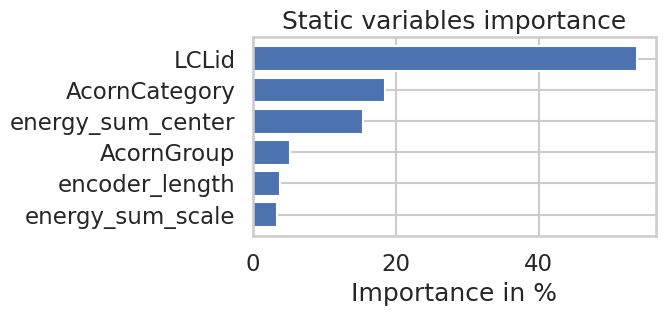

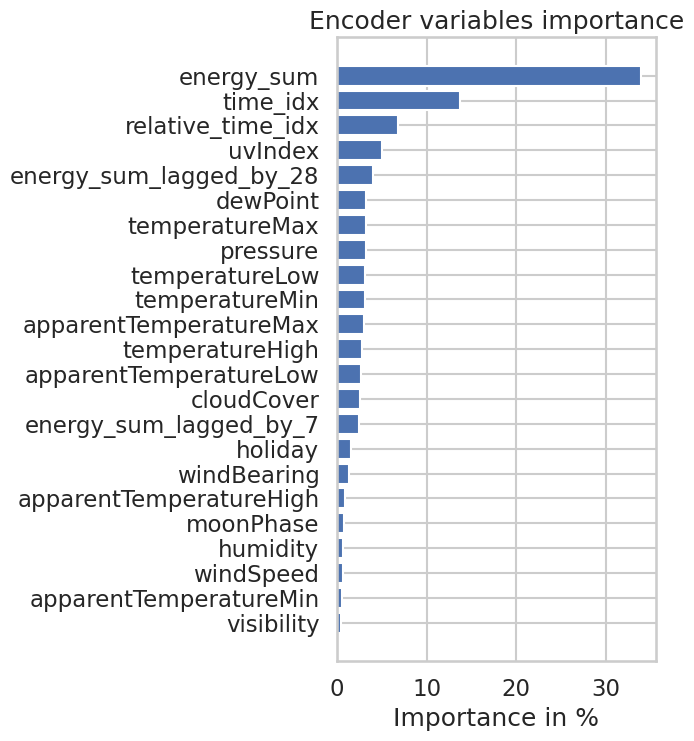

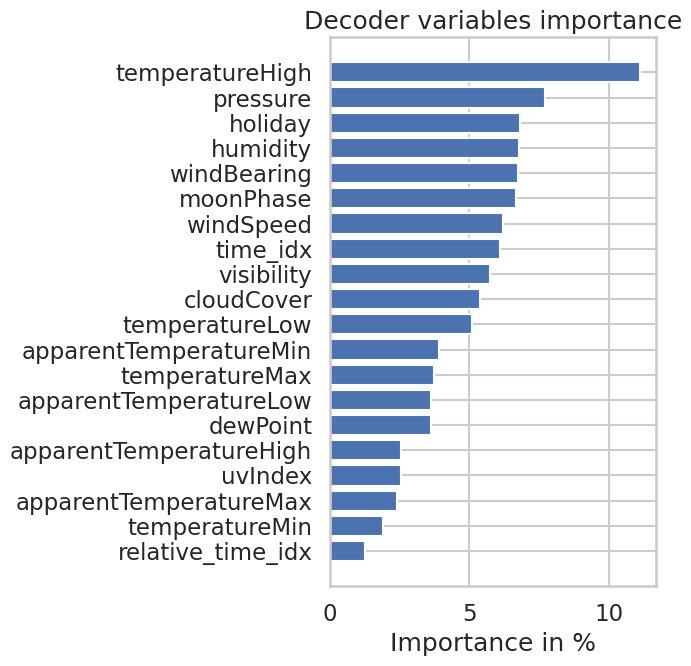

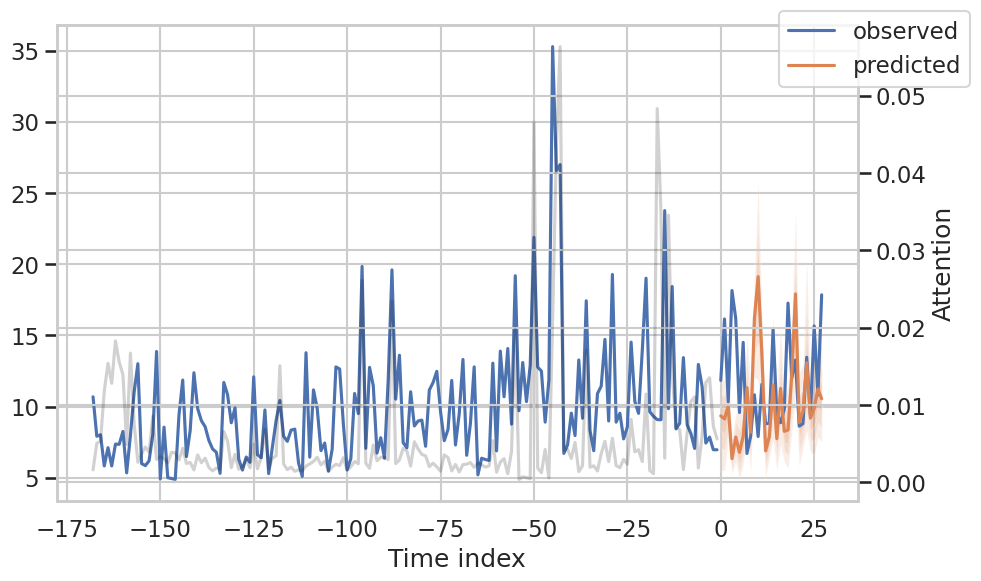

In [16]:
# ===================== INTERPRETABILITY (fixed) =====================
import numpy as np

# 1) Median predictions + per-variable comparison (prediction vs actual)
#    Returns inputs (x) and median forecasts; used to compute feature-wise errors
val_pred = tft.predict(
    val_dataloader,
    mode="prediction",   # median (q=0.5)
    return_x=True,
)

pred_vs_actual = tft.calculate_prediction_actual_by_variable(val_pred.x, val_pred.output)

# Keep plots tidy: drop any features whose names contain "lag" or "lagged"
all_features = list(pred_vs_actual["support"].keys())
plot_features = [f for f in all_features if ("lag" not in f.lower() and "lagged" not in f.lower())]

print(f"[INFO] Will plot {len(plot_features)}/{len(all_features)} features. Examples:", plot_features[:10])
for feature in plot_features:
    try:
        tft.plot_prediction_actual_by_variable(pred_vs_actual, name=feature)
    except Exception as e:
        print(f"[WARN] Could not plot '{feature}': {e}")

# 2) Raw outputs for interpretation (variable importances, attention, etc.)
val_raw = tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
)

# Aggregate interpretation across the batch (sum reduction)
interpretation = tft.interpret_output(val_raw.output, reduction="sum")
tft.plot_interpretation(interpretation)

# ---------- Retrieve feature names from the dataset object ----------
def _as_list(x):
    return list(x) if isinstance(x, (list, tuple)) else ([] if x is None else [x])

static_categoricals = _as_list(getattr(training_dataset, "static_categoricals", []))
static_reals        = _as_list(getattr(training_dataset, "static_reals", []))

tv_known_cats  = _as_list(getattr(training_dataset, "time_varying_known_categoricals", []))
tv_known_reals = _as_list(getattr(training_dataset, "time_varying_known_reals", []))
tv_unk_reals   = _as_list(getattr(training_dataset, "time_varying_unknown_reals", []))  # usually ['energy_sum']

# TFT naming:
# - static_variables = static_categoricals + static_reals
# - encoder_variables = time-varying known + unknown (target) in encoder
# - decoder_variables = time-varying known (future-known) in decoder
static_names  = static_categoricals + static_reals
encoder_names = tv_known_cats + tv_known_reals + tv_unk_reals
decoder_names = tv_known_cats + tv_known_reals

# ---------- Convert tensors to (name, value) pairs & print top-k ----------
def topk_from_tensor(tensor, names, k=10):
    arr = tensor.detach().cpu().numpy().astype(float).ravel()
    n = min(len(arr), len(names))  # guard if lengths differ
    pairs = list(zip(names[:n], arr[:n]))
    return sorted(pairs, key=lambda kv: kv[1], reverse=True)[:k]

print("\n[Static variables - top 10]")
print(topk_from_tensor(interpretation["static_variables"], static_names, k=10))

print("\n[Encoder variables (time-varying) - top 10]")
print(topk_from_tensor(interpretation["encoder_variables"], encoder_names, k=10))

print("\n[Decoder variables (time-varying future-known) - top 10]")
print(topk_from_tensor(interpretation["decoder_variables"], decoder_names, k=10))

# Plot a single validation example to inspect time-wise decomposition/attention
idx = 0
tft.plot_prediction(val_raw.x, val_raw.output, idx=idx)


INFO: Seed set to 42


[INFO] Using provided checkpoint: /kaggle/input/tftdienluc/tft_logs/tft/version_0/checkpoints/tft-epoch=00-val_loss=1.5736.ckpt


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-09-28 17:07:03.711479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT

[SAVED] Predictions saved to: /kaggle/working/tft_test_predictions.csv
MAE: 3.034 kWh | RMSE: 5.237 kWh | NMAE_macro: 0.293 | MAPE: 384.50%


/tmp/ipykernel_36/3455172797.py:242: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_id = df_eval.groupby("LCLid").apply(
/tmp/ipykernel_36/3455172797.py:261: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  h_mae = df_eval.groupby("h").apply(lambda g: np.mean(np.abs(g["median"]-g["energy_sum"])))


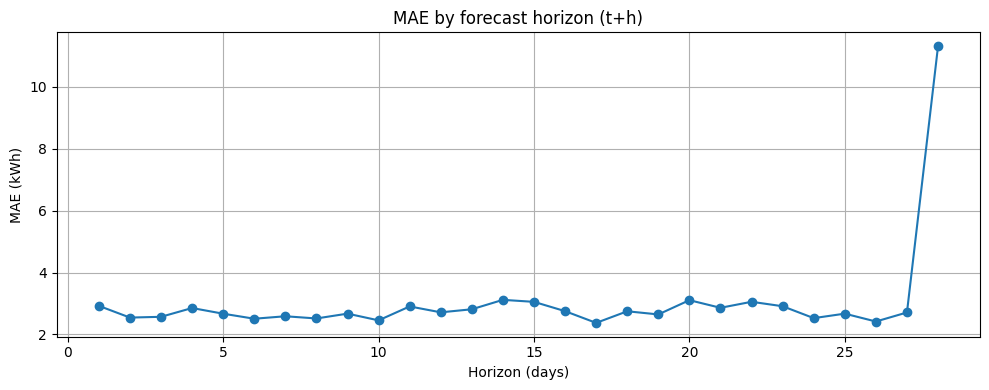

Coverage (10–90%): 0.784 | Winkler score: 15.151


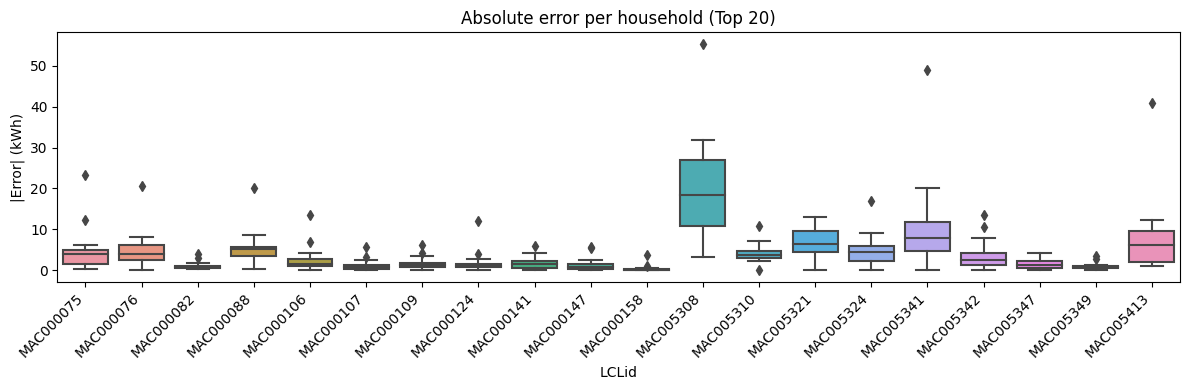

[DONE] Inference + evaluation complete.


In [4]:
# ============================ SETUP & IMPORTS ============================
# Core libs, plotting, Torch & PyTorch Forecasting (TFT)
import os, math, numpy as np, pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder

pl.seed_everything(42, workers=True)  # reproducibility

# ============================ PATHS & CONFIG =============================
DATA_CLEAN = Path("/kaggle/working/finaldf_169.csv")  # preprocessed 169-household panel
SAVE_DIR   = Path("/kaggle/working/tft_logs")         # Lightning logs/checkpoints
PRED_OUT   = Path("/kaggle/working/tft_test_predictions.csv")

# If you already know the best checkpoint, set it here; otherwise auto-find below
BEST_CKPT = "/kaggle/input/tftdienluc/tft_logs/tft/version_0/checkpoints/tft-epoch=00-val_loss=1.5736.ckpt"
# BEST_CKPT = None  # enable auto-discovery under SAVE_DIR

# Same sequence setup as training
H  = 28            # prediction horizon (days)
MAX_ENCODER = 168  # encoder context (days)

# Candidate daily weather fields (DarkSky schema)
weather_cols_all = [
    "temperatureMax","windBearing","dewPoint","cloudCover","windSpeed","pressure",
    "apparentTemperatureHigh","visibility","humidity","apparentTemperatureLow",
    "apparentTemperatureMax","uvIndex","temperatureLow","temperatureMin",
    "temperatureHigh","apparentTemperatureMin","moonPhase"
]

# ============================ LOAD & REBUILD DATA ========================
assert DATA_CLEAN.exists(), f"Missing {DATA_CLEAN}"
df = pd.read_csv(DATA_CLEAN, low_memory=False)

# Minimal normalization & key checks
required = {"day","LCLid","energy_sum"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"
df["day"] = pd.to_datetime(df["day"], errors="coerce")
df = df.dropna(subset=["day","LCLid","energy_sum"]).copy()

# Global time index (build if absent); also keep date_map for time_idx -> day
if "time_idx" not in df.columns:
    date_map = (
        df[["day"]].drop_duplicates().sort_values("day").reset_index(drop=True)
        .rename_axis("time_idx").reset_index()
    )
    date_map["time_idx"] = date_map["time_idx"] + 1
    df = df.merge(date_map, on="day", how="left")
else:
    date_map = df[["day","time_idx"]].drop_duplicates().sort_values("time_idx")

# Light categorical cleanup
for col in ["AcornGroup","AcornCategory","LCLid","Tariff"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().replace({"nan":"Unknown","None":"Unknown"})

# Rebuild clean daily weather (time interpolation + median backfill), then merge back
wcols = [c for c in weather_cols_all if c in df.columns]
if wcols:
    weather_daily = (
        df[["day"] + wcols].groupby("day", as_index=True).first().sort_index()
    )
    weather_daily[wcols] = weather_daily[wcols].interpolate(method="time", limit_direction="both")
    for c in wcols:
        if weather_daily[c].isna().any():
            weather_daily[c] = weather_daily[c].fillna(weather_daily[c].median())
    df = df.drop(columns=wcols, errors="ignore").merge(
        weather_daily[wcols].reset_index(), on="day", how="left"
    )

# Build list of known real-valued covariates (time_idx, holiday, weather, *_was_missing)
known_reals = ["time_idx"]
if "holiday" in df.columns:
    df["holiday"] = pd.to_numeric(df["holiday"], errors="coerce").fillna(0).astype(np.float32)
    known_reals.append("holiday")
known_reals += [c for c in weather_cols_all if c in df.columns]
known_reals += [c for c in df.columns if c.endswith("_was_missing")]

# ============================ SPLIT (train/val/test) =====================
# Same rolling scheme used during training: ... | +28 (val) | +28 (test)
last_idx = int(df["time_idx"].max())
train_cutoff = last_idx - 2*H
val_end      = train_cutoff + H
test_end     = last_idx

df_train = df[df["time_idx"] <= train_cutoff].copy()
df_val   = df[df["time_idx"] <= val_end].copy()
df_test  = df[df["time_idx"] <= test_end].copy()

# ============================ FEATURE ROLES ==============================
# A column is static if each household has a single unique value for it
def is_static_by_group(column):
    nun = df.groupby("LCLid")[column].nunique(dropna=False)
    return nun.max() == 1

static_categoricals = ["LCLid"]
cat_candidates = [c for c in ["AcornGroup","AcornCategory"] if c in df.columns]
time_varying_known_categoricals = []
for c in cat_candidates:
    if is_static_by_group(c):
        static_categoricals.append(c)
    else:
        time_varying_known_categoricals.append(c)

time_varying_unknown_reals = ["energy_sum"]  # target
categorical_encoders = {
    c: NaNLabelEncoder(add_nan=True)
    for c in (static_categoricals + time_varying_known_categoricals)
}

# ============================ DATASETS & DATALOADERS =====================
# Recreate TimeSeriesDataSet exactly as trained (lags, encodings, normalizer)
training_dataset = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="energy_sum",
    group_ids=["LCLid"],

    min_encoder_length=MAX_ENCODER // 2,
    max_encoder_length=MAX_ENCODER,
    min_prediction_length=H,
    max_prediction_length=H,

    static_categoricals=static_categoricals,
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,

    categorical_encoders=categorical_encoders,

    target_normalizer=GroupNormalizer(groups=["LCLid"], transformation="softplus"),
    lags={"energy_sum": [7, 28]},  # add 365 if sequences are long enough

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,

    allow_missing_timesteps=True,
)

# Clone dataset schema for val/test
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_val, predict=True, stop_randomization=True
)
test_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_test, predict=True, stop_randomization=True
)

# Dataloader for test inference
BATCH_SIZE = 128
NUM_WORKERS = 2
test_dataloader = test_dataset.to_dataloader(
    train=False, batch_size=BATCH_SIZE*4, num_workers=NUM_WORKERS, drop_last=False
)

# ============================ LOAD BEST CHECKPOINT =======================
# Use provided ckpt; otherwise, discover the lowest-val_loss ckpt under SAVE_DIR
if BEST_CKPT is None:
    ckpts = list(SAVE_DIR.rglob("checkpoints/*.ckpt"))
    assert len(ckpts) > 0, f"No checkpoints found under {SAVE_DIR}"
    def _ckpt_score(p):
        name = p.name
        if "val_loss=" in name:
            try:
                return float(name.split("val_loss=")[-1].split(".ckpt")[0])
            except:
                return np.inf
        return np.inf
    ckpts_sorted = sorted(ckpts, key=_ckpt_score)
    BEST_CKPT = str(ckpts_sorted[0])
    print(f"[INFO] Auto-selected checkpoint: {BEST_CKPT}")
else:
    print(f"[INFO] Using provided checkpoint: {BEST_CKPT}")

best_tft = TemporalFusionTransformer.load_from_checkpoint(BEST_CKPT)

# ============================ INFERENCE (RAW) ============================
# Predict with mode="raw" to get full quantiles + indices for horizon expansion
test_pred = best_tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True,   # DataFrame-like index: group_ids + start time_idx
    return_x=True,
)

# Extract tensors and quantile grid
yhat = test_pred.output["prediction"]  # shape: [N, H, Q]
N, Hh, Q = yhat.shape
quantiles = np.array(best_tft.loss.quantiles)
yhat_np = yhat.detach().cpu().numpy()

# Expand per-sample start index to per-step time_idx across the horizon
idx_df = test_pred.index.copy().reset_index(drop=True)
rep_idx = np.repeat(idx_df.index.values, Hh)
base    = idx_df.loc[rep_idx, "time_idx"].to_numpy()
steps   = np.tile(np.arange(Hh), N)
time_idx_h = base + steps

# Assemble tidy prediction frame with calendar day
pred_df = pd.DataFrame({
    "LCLid": idx_df.loc[rep_idx, "LCLid"].to_numpy(),
    "time_idx": time_idx_h,
})
pred_df = pred_df.merge(date_map[["time_idx","day"]], on="time_idx", how="left")

# Attach all quantiles and the median point forecast (q=0.50)
yhat_flat = yhat_np.reshape(N*Hh, Q)
for qi, q in enumerate(quantiles):
    pred_df[f"q{q:.2f}"] = yhat_flat[:, qi]

if 0.5 in quantiles:
    pred_df["median"] = pred_df[f"q{0.5:.2f}"]
else:
    mid_idx = int(np.argmin(np.abs(quantiles - 0.5)))
    pred_df["median"] = yhat_flat[:, mid_idx]

# Merge ground truth for scoring (if present)
gt_cols = ["LCLid","time_idx","energy_sum"]
if set(gt_cols).issubset(df_test.columns):
    gt = df_test[gt_cols].copy()
    pred_df = pred_df.merge(gt, on=["LCLid","time_idx"], how="left", suffixes=("","_actual"))

pred_df = pred_df.sort_values(["LCLid","time_idx"]).reset_index(drop=True)
pred_df.to_csv(PRED_OUT, index=False)
print(f"[SAVED] Predictions saved to: {PRED_OUT}")

# ============================ EVALUATION METRICS =========================
# Use median vs energy_sum for deterministic scoring
df_eval = pred_df.dropna(subset=["median","energy_sum"]).copy()

# (1) Overall scores
mae  = np.mean(np.abs(df_eval["median"] - df_eval["energy_sum"]))
rmse = np.sqrt(np.mean((df_eval["median"] - df_eval["energy_sum"])**2))

# Household-level macro NMAE (average of per-household NMAE)
by_id = df_eval.groupby("LCLid").apply(
    lambda g: np.mean(np.abs(g["median"]-g["energy_sum"])) / (g["energy_sum"].mean()+1e-6)
)
nmae_macro = by_id.mean()

# MAPE with guard for near-zero targets
mask = df_eval["energy_sum"].abs() > 1e-3
mape = (np.abs(df_eval.loc[mask,"median"] - df_eval.loc[mask,"energy_sum"])
        / df_eval.loc[mask,"energy_sum"].abs()).mean() * 100

print(f"MAE: {mae:.3f} kWh | RMSE: {rmse:.3f} kWh | NMAE_macro: {nmae_macro:.3f} | MAPE: {mape:.2f}%")

# (2) Horizon-wise MAE (t+h), assuming each sample expands to H consecutive rows
df_eval = df_eval.sort_values(["LCLid","time_idx"]).copy()
df_eval["block_id"] = (df_eval["LCLid"].shift(1) != df_eval["LCLid"]).cumsum()
df_eval["h"] = df_eval.groupby("block_id").cumcount()  # 0..H-1

h_mae = df_eval.groupby("h").apply(lambda g: np.mean(np.abs(g["median"]-g["energy_sum"])))
plt.figure(figsize=(10,4))
plt.plot(h_mae.index+1, h_mae.values, marker="o")
plt.title("MAE by forecast horizon (t+h)"); plt.xlabel("Horizon (days)"); plt.ylabel("MAE (kWh)")
plt.grid(True); plt.tight_layout(); plt.show()

# (3) Coverage & Winkler score for 10–90% interval (if available)
if {"q0.10","q0.90"}.issubset(df_eval.columns):
    lower, upper, y = df_eval["q0.10"], df_eval["q0.90"], df_eval["energy_sum"]
    picp = np.mean((y >= lower) & (y <= upper))  # expected ~0.80
    alpha = 0.2
    width = (upper - lower).clip(lower=0)
    penalty = 2/alpha * ((lower - y).clip(lower=0) + (y - upper).clip(lower=0))
    winkler = np.mean(width + penalty)
    print(f"Coverage (10–90%): {picp:.3f} | Winkler score: {winkler:.3f}")
else:
    print("[INFO] Missing q0.10/q0.90 columns for coverage metrics.")

# (4) Error breakdowns: per household (boxplot) & by ACORN groups (bar)
df_eval["abs_err"] = np.abs(df_eval["median"] - df_eval["energy_sum"])

plt.figure(figsize=(12,4))
top_ids = df_eval["LCLid"].value_counts().index[:20]
sns.boxplot(data=df_eval[df_eval["LCLid"].isin(top_ids)], x="LCLid", y="abs_err")
plt.xticks(rotation=45, ha="right"); plt.title("Absolute error per household (Top 20)")
plt.ylabel("|Error| (kWh)"); plt.tight_layout(); plt.show()

for col in ["AcornCategory","AcornGroup"]:
    if col in pred_df.columns:
        tmp = df_eval.groupby(col)["abs_err"].mean().sort_values()
        plt.figure(figsize=(8,4))
        sns.barplot(x=tmp.index, y=tmp.values)
        plt.xticks(rotation=30, ha="right"); plt.title(f"Average MAE by {col}")
        plt.ylabel("MAE (kWh)"); plt.tight_layout(); plt.show()

print("[DONE] Inference + evaluation complete.")


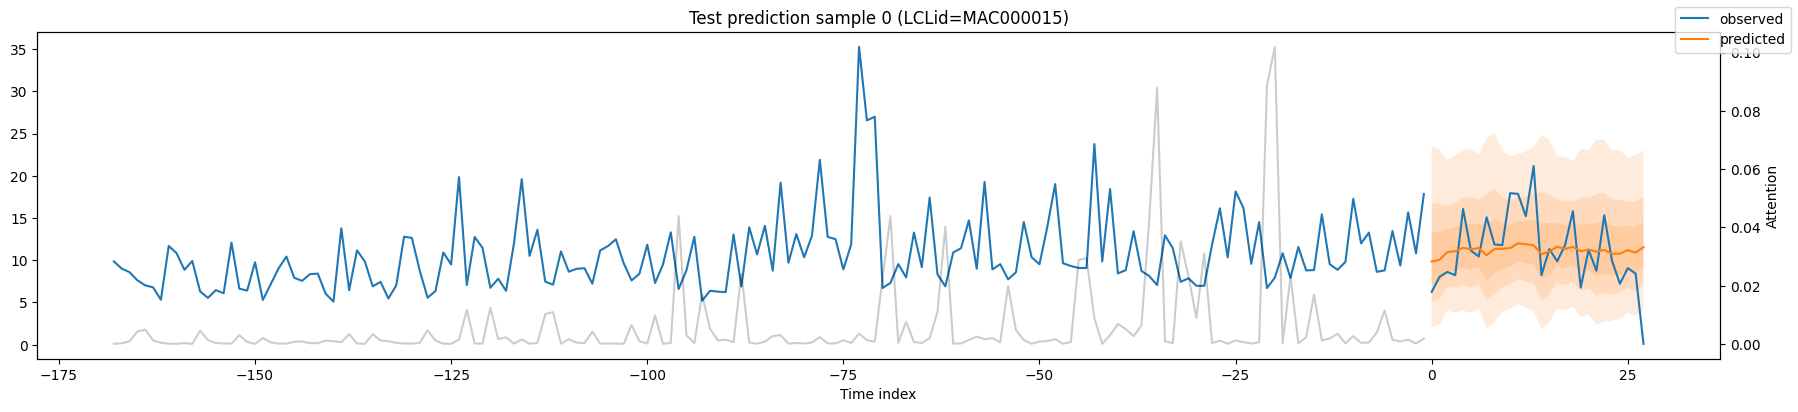

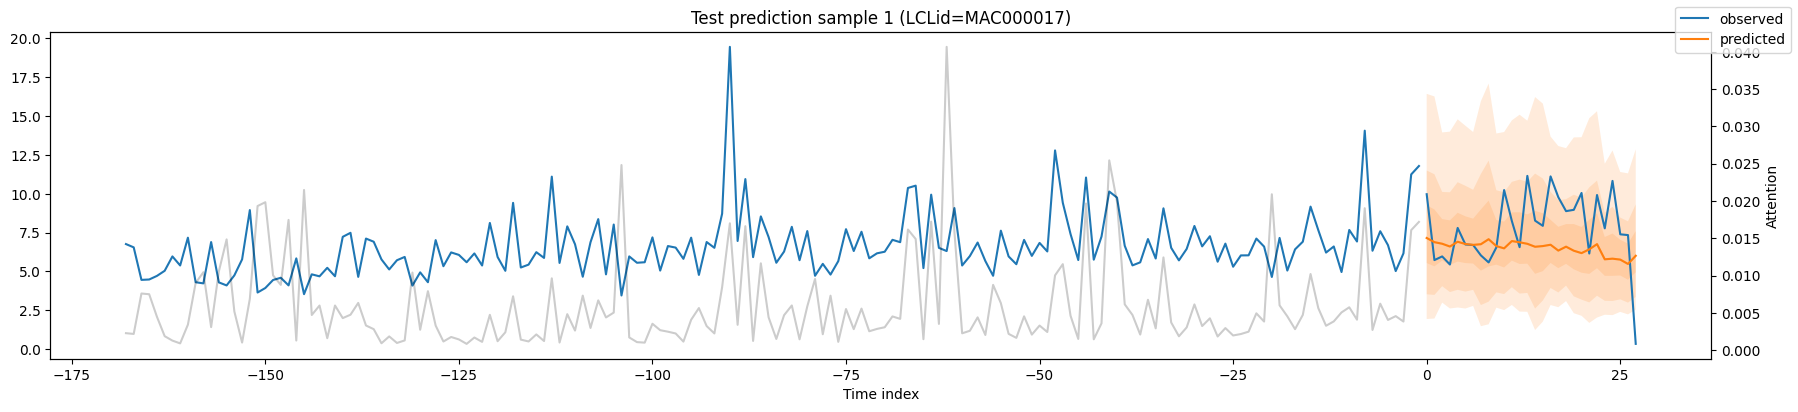

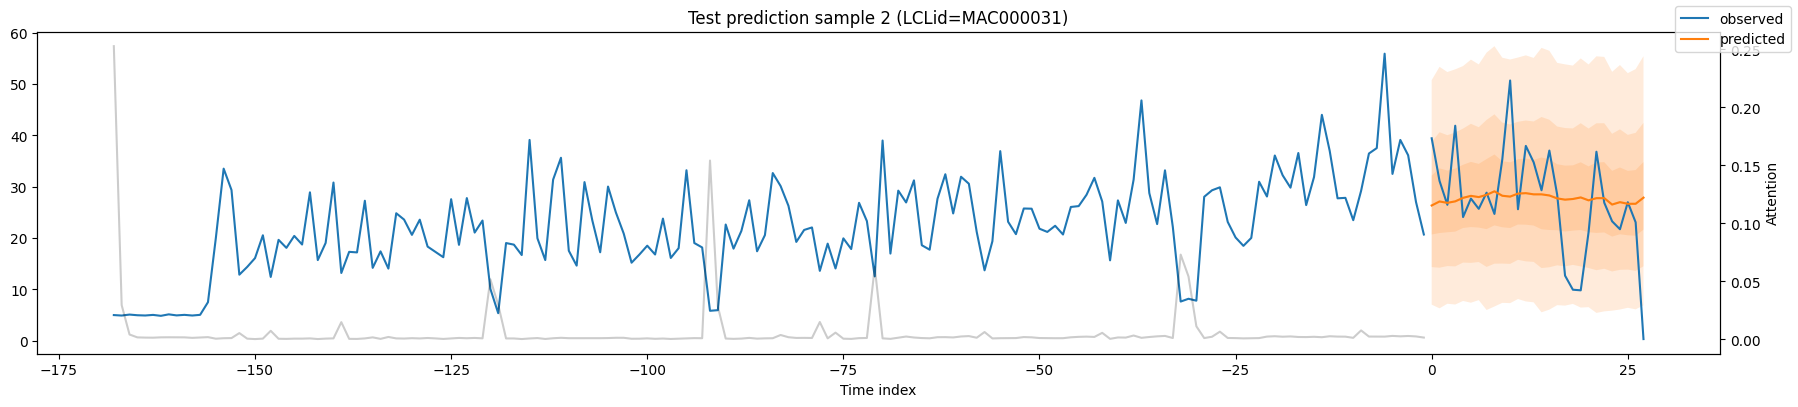

In [6]:
import matplotlib.pyplot as plt

# Plot 3 prediction samples (can adjust number as needed)
n_plot = min(3, len(idx_df))  # ensure we don’t exceed available samples
for i in range(n_plot):
    fig, ax = plt.subplots(figsize=(18,4))
    best_tft.plot_prediction(
        test_pred.x,          # input features returned from predict(return_x=True)
        test_pred.output,     # raw model outputs (forecast distribution/quantiles)
        idx=i,                # index of the sample to visualize
        show_future_observed=True,  # also plot the actual observed values in forecast window
        ax=ax,                # axis object to draw on
    )
    # Add title with sample index and household ID for clarity
    ax.set_title(f"Test prediction sample {i} (LCLid={idx_df.loc[i,'LCLid']})")
    plt.show()
